Start!!
min_x: -10
min_y: -10
max_x: 60
max_y: 60
x_width: 35
y_width: 35


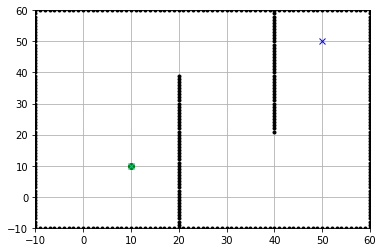

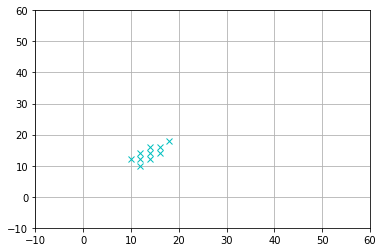

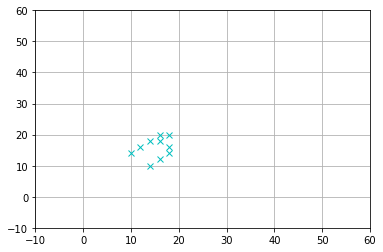

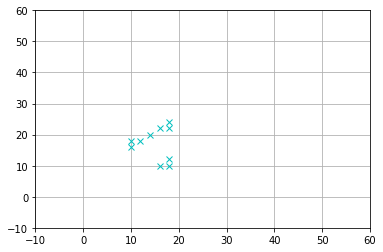

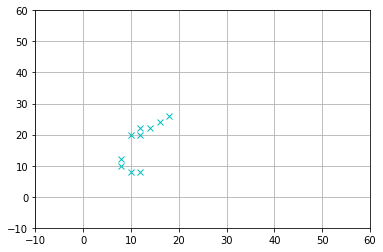

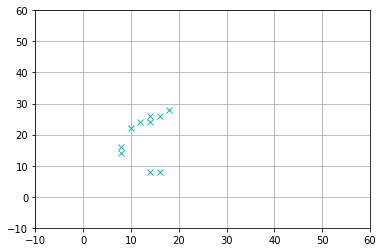

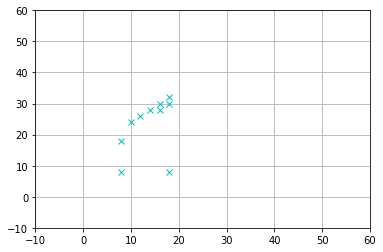

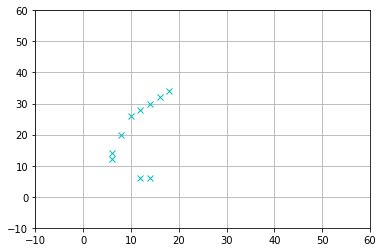

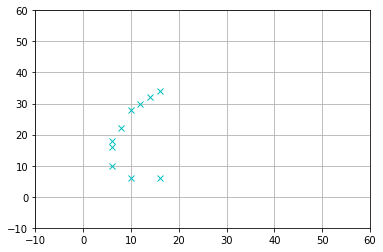

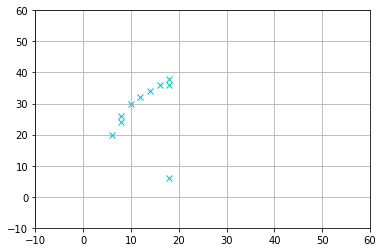

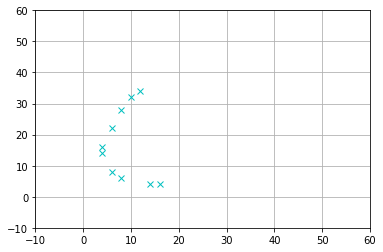

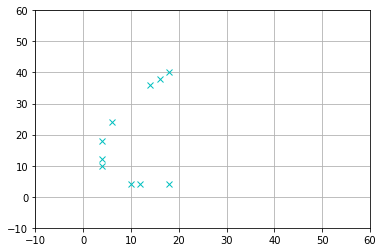

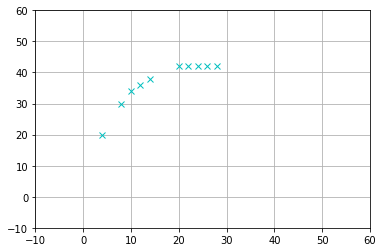

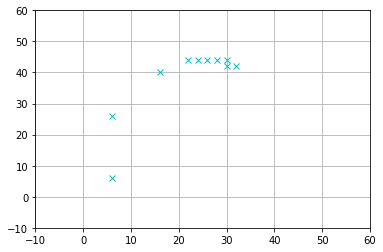

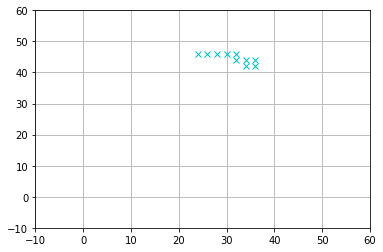

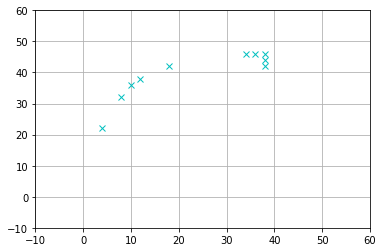

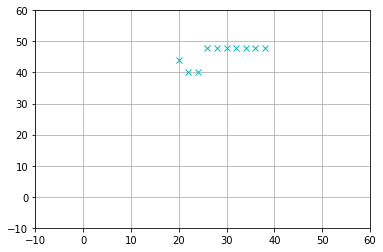

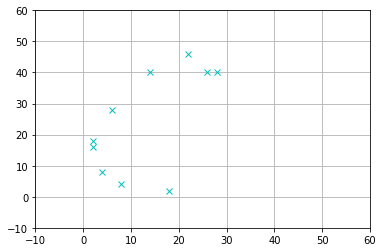

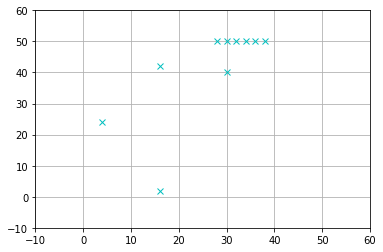

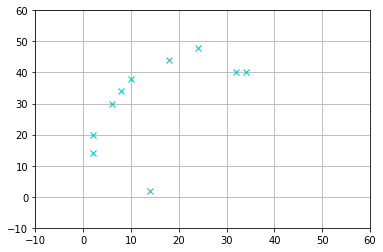

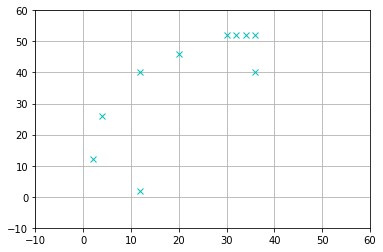

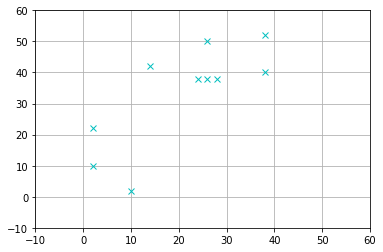

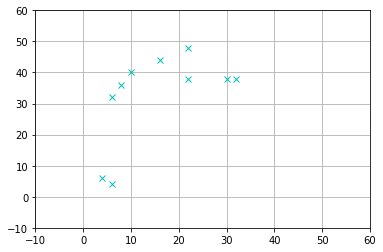

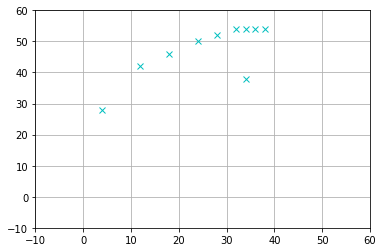

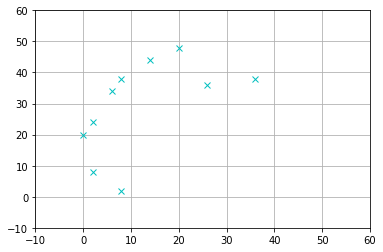

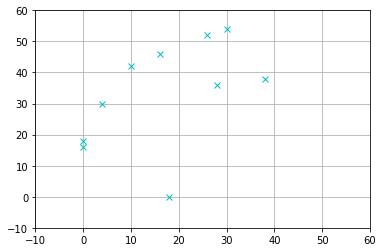

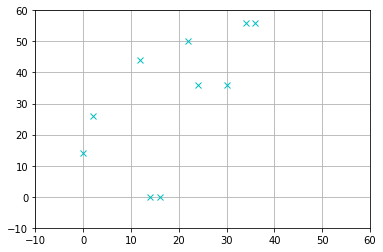

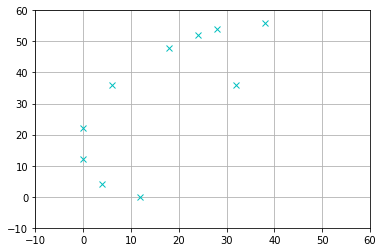

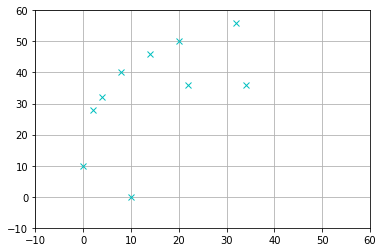

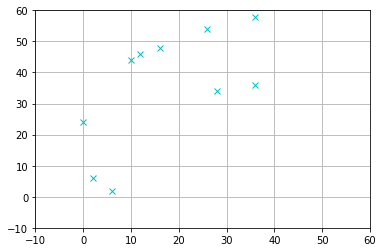

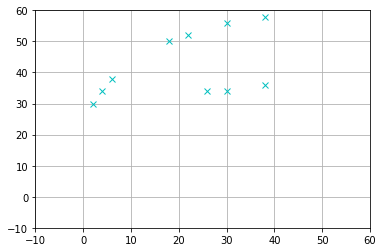

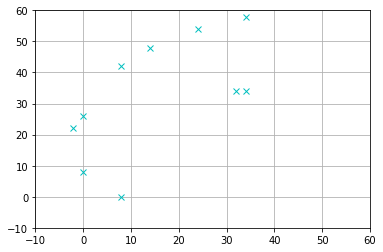

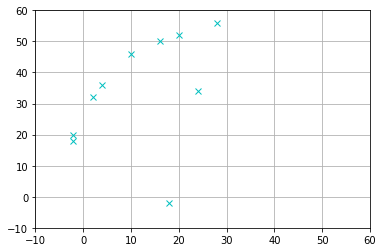

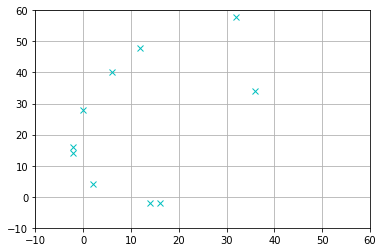

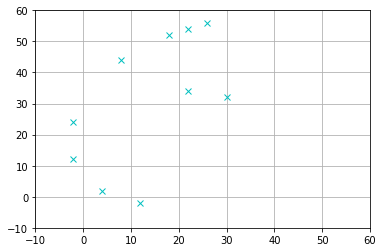

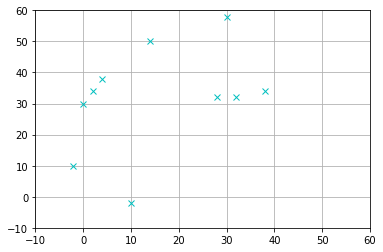

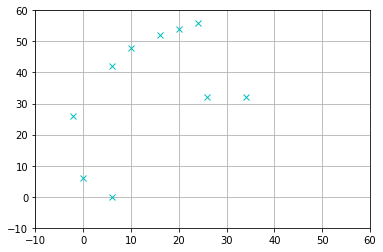

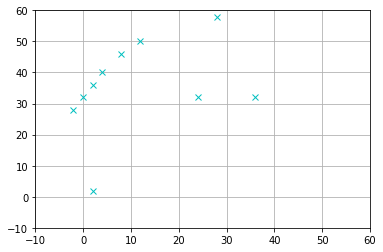

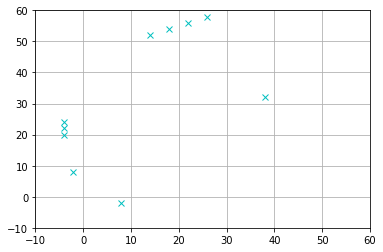

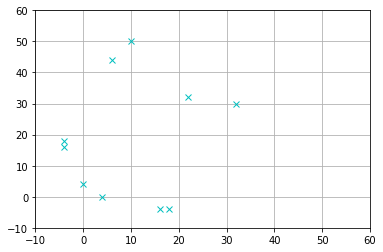

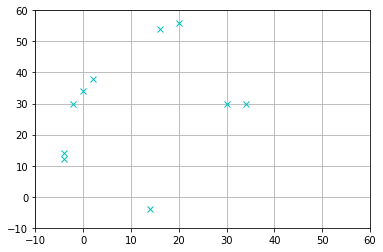

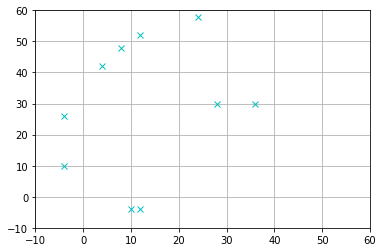

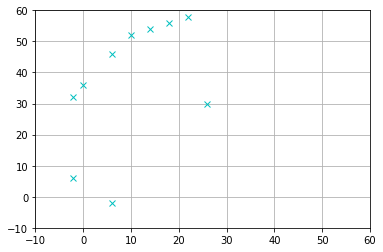

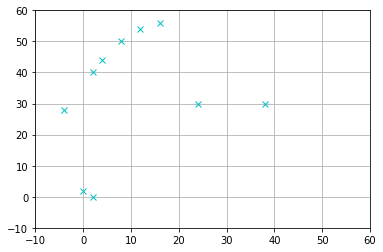

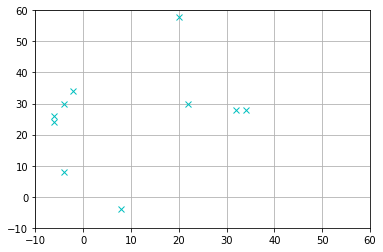

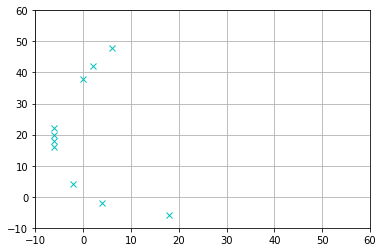

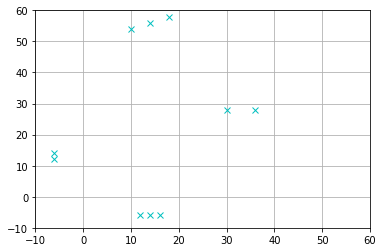

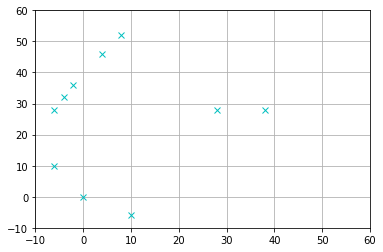

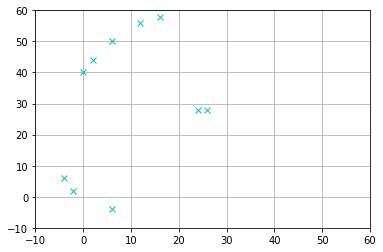

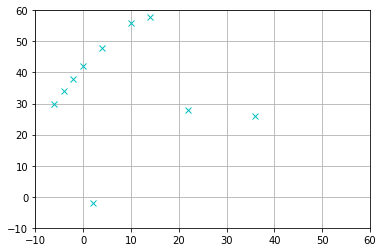

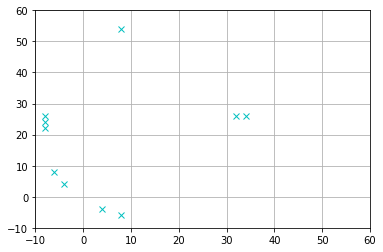

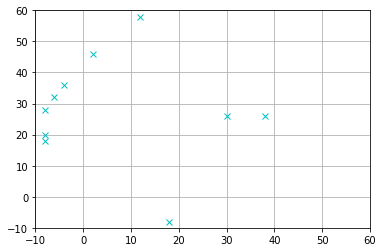

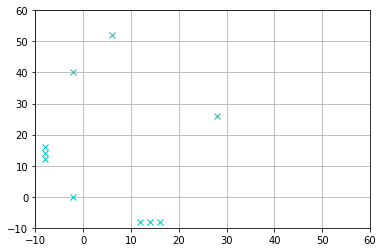

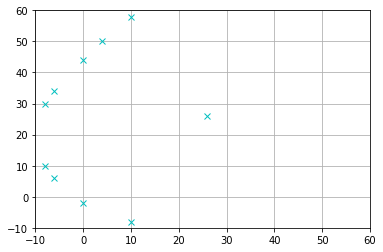

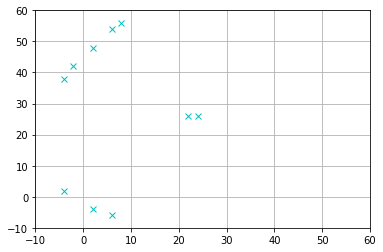

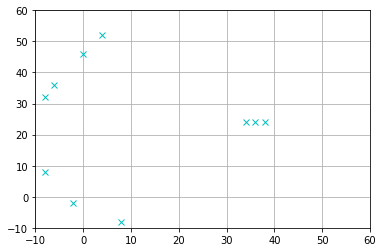

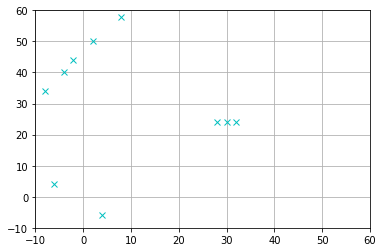

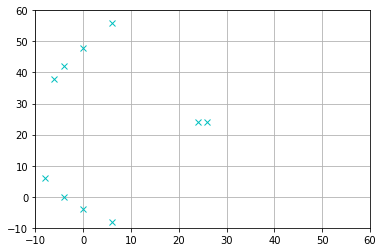

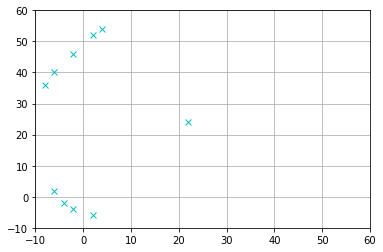

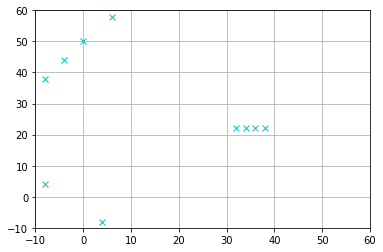

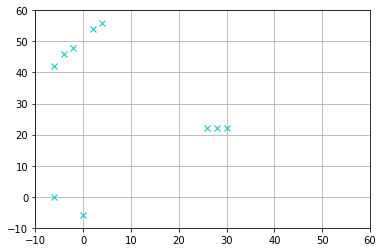

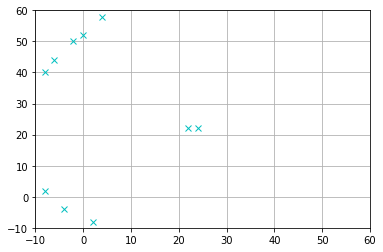

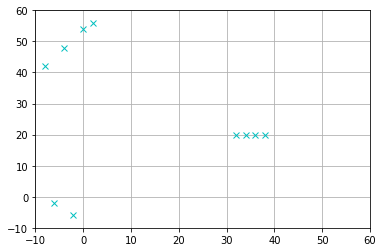

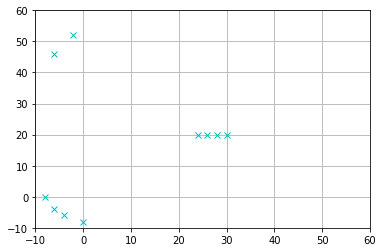

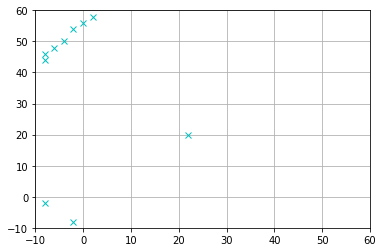

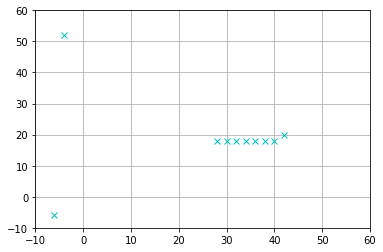

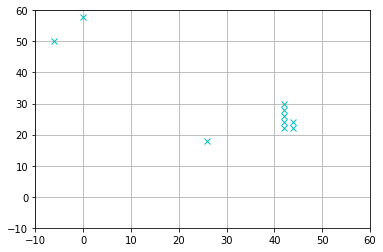

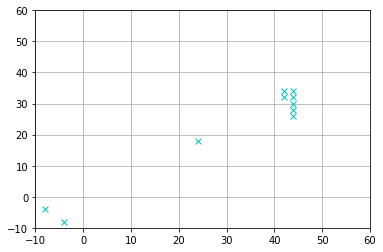

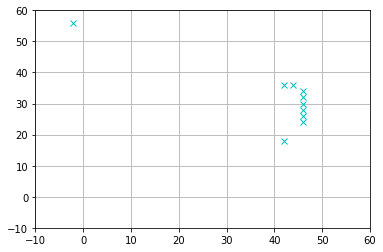

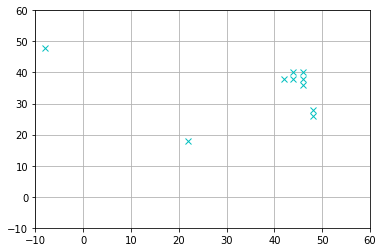

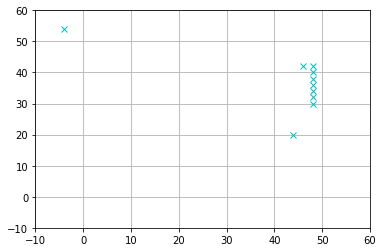

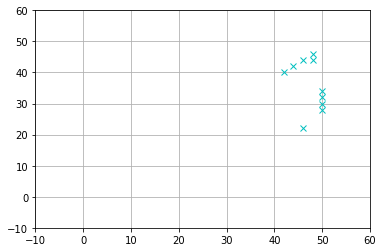

Find goal


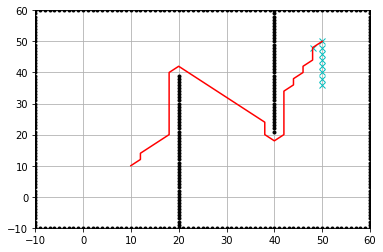

In [1]:
'''
A star grid planner

See Wikipedia article (https://en.wikipedia.org/wiki/A*_search_algorithm)
See Youtube (https://www.youtube.com/watch?v=icZj67PTFhc)
'''

import math
import matplotlib.pyplot as plt

show_animation = True
fig_min_x = -10
fig_min_y = -10
fig_max_x = 60
fig_max_y = 60

class AStarPlanner:
    def __init__(self, ox, oy, resolution, rr):
        """
        Initialize grid map
        ox: x position list of obstaclesL
        oy: y position list of obstacles
        resolution: grid resolution
        rr: robot radius
        """
        self.resolution = resolution
        self.rr = rr
        self.min_x, self.max_x = 0, 0
        self.min_y, self.max_y = 0, 0
        self.obstacle_map = None
        self.x_width, self.y_width = 0, 0
        self.motion = self.get_motion_model()
        self.calc_obstacle_map(ox, oy)

    class Node:
        def __init__(self, x, y, cost, parent_index):
            """
            Initialize a node
            """
            self.x = x
            self.y = y
            self.cost = cost
            self.parent_index = parent_index

        def __str__(self):
            return "Node info: " + str(self.x) + "," + str(self.y) + "," + str(self.cost) + "," + str(self.parent_index)

    def planning(self, sx, sy, gx, gy):
        """
        A star path search

        input:
            s_x: start x position [m]
            s_y: start y position [m]
            gx: goal x position [m]
            gy: goal y position [m]

        output:
            rx: x position list of the final path
            ry: y position list of the final path
        """

        start_node = self.Node(self.calc_xy_index(sx, self.min_x),
                               self.calc_xy_index(sy, self.min_y), 0.0, -1)
        goal_node = self.Node(self.calc_xy_index(gx, self.min_x),
                              self.calc_xy_index(gy, self.min_y), 0.0, -1)

        open_set, closed_set = dict(), dict()
        open_set[self.calc_grid_index(start_node)] = start_node

        while 1:
            if len(open_set) == 0:
                print("Open set is empty..")
                break

            c_id = min(open_set, key=lambda o: open_set[o].cost + self.calc_heuristic(goal_node, open_set[o]))
            current = open_set[c_id]

            # show graph
            if show_animation:  # pragma: no cover
                plt.plot(self.calc_grid_position(current.x, self.min_x),
                         self.calc_grid_position(current.y, self.min_y), "xc")
                plt.grid(True)
                plt.xlim(fig_min_x, fig_max_x)
                plt.ylim(fig_min_y, fig_max_y)
                # for stopping simulation with the esc key.
                plt.gcf().canvas.mpl_connect('key_release_event',
                                             lambda event: [exit(
                                                 0) if event.key == 'escape' else None])
                if len(closed_set.keys()) % 10 == 0:
                    plt.pause(0.001)

            if current.x == goal_node.x and current.y == goal_node.y:
                print("Find goal")
                goal_node.parent_index = current.parent_index
                goal_node.cost = current.cost
                break

            # Remove the item from the open set
            del open_set[c_id]

            # Add it to the closed set
            closed_set[c_id] = current

            # expand_grid search grid based on motion model
            for i, _ in enumerate(self.motion):
                node = self.Node(current.x + self.motion[i][0],
                                 current.y + self.motion[i][1],
                                 current.cost + self.motion[i][2], c_id)
                n_id = self.calc_grid_index(node)

                # If the node is not safe, do nothing
                if not self.verify_node(node):
                    continue

                if n_id in closed_set:
                    continue

                if n_id not in open_set:
                    open_set[n_id] = node  # discovered a new node
                else:
                    if open_set[n_id].cost > node.cost:
                        # This path is the best until now. record it
                        open_set[n_id] = node

        rx, ry = self.calc_final_path(goal_node, closed_set)

        return rx, ry

    def calc_final_path(self, goal_node, closed_set):
        # generate final course
        rx, ry = [self.calc_grid_position(goal_node.x, self.min_x)], [self.calc_grid_position(goal_node.y, self.min_y)]
        parent_index = goal_node.parent_index
        while parent_index != -1:
            n = closed_set[parent_index]
            rx.append(self.calc_grid_position(n.x, self.min_x))
            ry.append(self.calc_grid_position(n.y, self.min_y))
            parent_index = n.parent_index

        return rx, ry

    def calc_xy_index(self, position, min_pos):
        """
        calc xy index

        input: 
            position: unrounded position
            min_pos: min position value
        return:
            position in grid
        """
        return round((position-min_pos) / self.resolution)

    def calc_grid_index(self, node):
        return (node.y - self.min_y) * self.x_width + (node.x - self.min_x)

    def calc_grid_position(self, index, min_pos):
        """
        calc grid position
        
        input:
            index: index of node
            min_pos: min position value
        return:
            position in grid
        """
        return index * self.resolution + min_pos

    @staticmethod
    def get_motion_model():
        # dx, dy, cost
        return [[1, 0, 1], 
                [0, 1, 1],
                [-1, 0, 1],
                [0, -1, 1],
                [-1, -1, math.sqrt(2)],
                [-1, 1, math.sqrt(2)],
                [1, -1, math.sqrt(2)],
                [1, 1, math.sqrt(2)]]
        
    @staticmethod
    def calc_heuristic(n1, n2):
        return math.hypot(n1.x - n2.x, n1.y - n2.y)

    def verify_node(self, node):
        px = self.calc_grid_position(node.x, self.min_x)
        py = self.calc_grid_position(node.y, self.min_y)

        if px < self.min_x:
            return False
        elif py < self.min_y:
            return False
        elif px >= self.max_x:
            return False
        elif py >= self.max_y:
            return False

        # collision check
        if self.obstacle_map[node.x][node.y]:
            return False

        return True
    
    def calc_obstacle_map(self, ox, oy):
        self.min_x = round(min(ox))
        self.min_y = round(min(oy))
        self.max_x = round(max(ox))
        self.max_y = round(max(oy))
        print("min_x:", self.min_x)
        print("min_y:", self.min_y)
        print("max_x:", self.max_x)
        print("max_y:", self.max_y)

        self.x_width = round((self.max_x - self.min_x) / self.resolution)
        self.y_width = round((self.max_y - self.min_y) / self.resolution)
        print("x_width:", self.x_width)
        print("y_width:", self.y_width)

        # obstacle map generation
        self.obstacle_map = [[False for _ in range(self.y_width)]
                             for _ in range(self.x_width)]
        for ix in range(self.x_width):
            x = self.calc_grid_position(ix, self.min_x)
            for iy in range(self.y_width):
                y = self.calc_grid_position(iy, self.min_y)
                for iox, ioy in zip(ox, oy):
                    d = math.hypot(iox - x, ioy - y)
                    if d <= self.rr:
                        self.obstacle_map[ix][iy] = True
                        break

def main():
    print("Start!!")

    # start and goal position
    sx = 10.0  # [m]
    sy = 10.0  # [m]
    gx = 50.0  # [m]
    gy = 50.0  # [m]
    grid_size = 2.0  # [m]
    robot_radius = 1.0  # [m]

    # set obstacle positions
    ox, oy = [], []
    for i in range(-10, 60):
        ox.append(i)
        oy.append(-10.0)
    for i in range(-10, 60):
        ox.append(60.0)
        oy.append(i)
    for i in range(-10, 61):
        ox.append(i)
        oy.append(60.0)
    for i in range(-10, 61):
        ox.append(-10.0)
        oy.append(i)
    for i in range(-10, 40):
        ox.append(20.0)
        oy.append(i)
    for i in range(0, 40):
        ox.append(40.0)
        oy.append(60.0 - i)
        
    # check obstacles
    if (min(ox) < fig_min_x) or (min(oy) < fig_min_y) or (max(ox) > fig_max_x) or (max(oy) > fig_max_y):
        print("Obstacle out of bounds")
        exit()

    if show_animation:  # pragma: no cover
        plt.plot(ox, oy, ".k")
        plt.plot(sx, sy, "og")
        plt.plot(gx, gy, "xb")
        plt.grid(True)
        plt.xlim(fig_min_x, fig_max_x)
        plt.ylim(fig_min_y, fig_max_y)

    a_star = AStarPlanner(ox, oy, grid_size, robot_radius)
    rx, ry = a_star.planning(sx, sy, gx, gy)

    if show_animation:  # pragma: no cover
        plt.plot(ox, oy, ".k")
        plt.plot(rx, ry, "-r")
        plt.grid(True)
        plt.xlim(fig_min_x, fig_max_x)
        plt.ylim(fig_min_y, fig_max_y)
        plt.pause(0.001)
        plt.show()


if __name__ == '__main__':
    main()

### Probabilistic Roadmaps
1. Conceived as a multi-query planner. Although it can handle single-query, it may not be the fastest planner to use. Other more efficient planners exist, e.g. EST and RRT.
2. 

 start!!


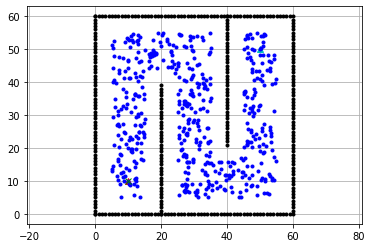

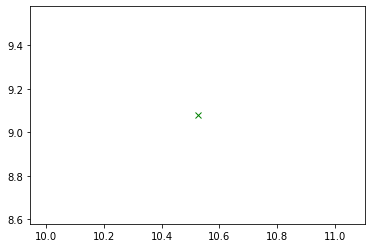

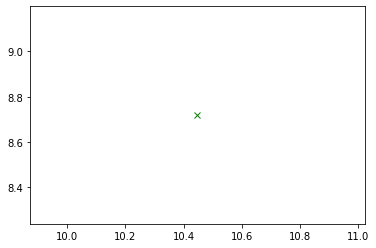

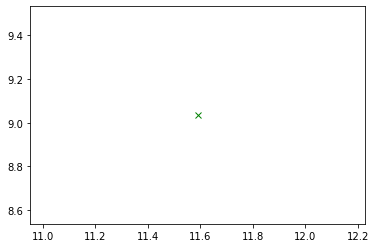

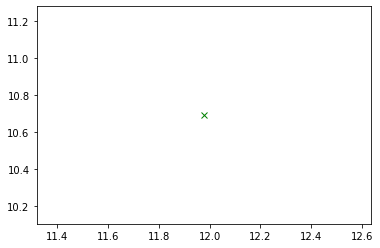

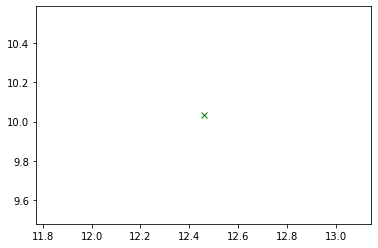

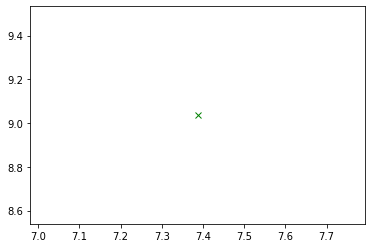

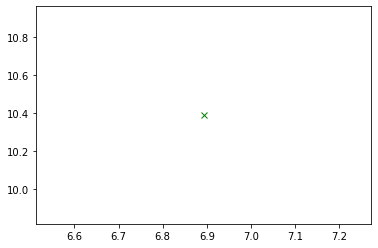

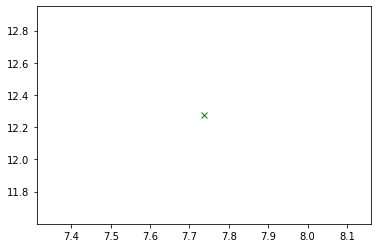

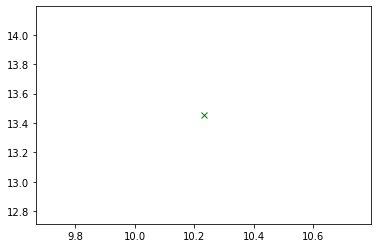

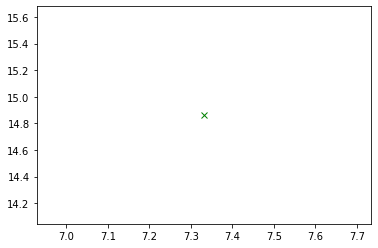

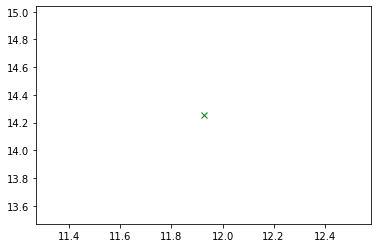

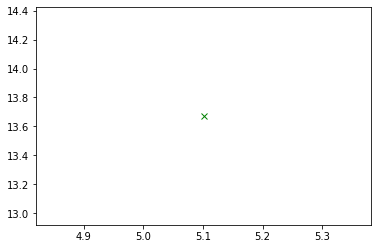

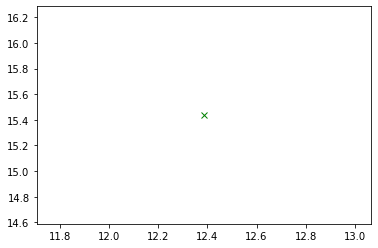

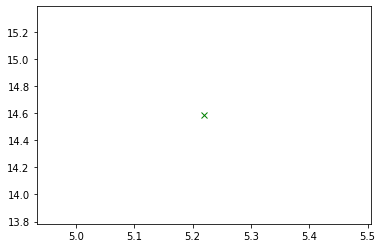

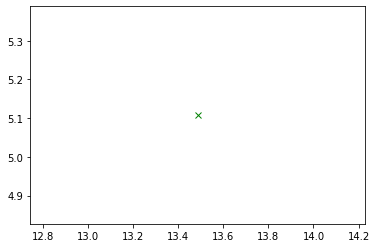

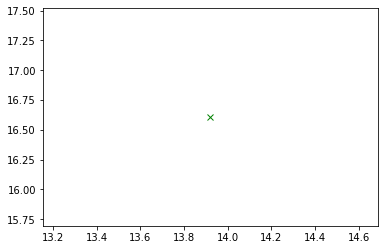

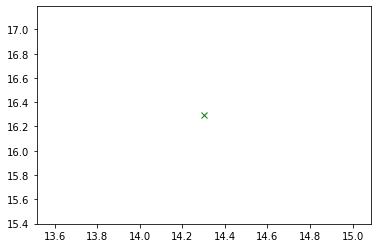

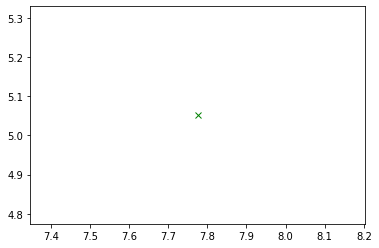

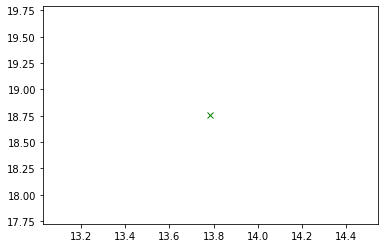

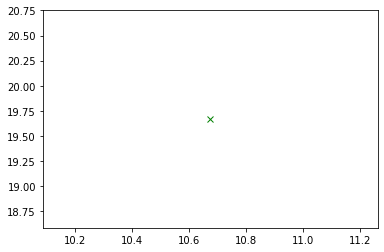

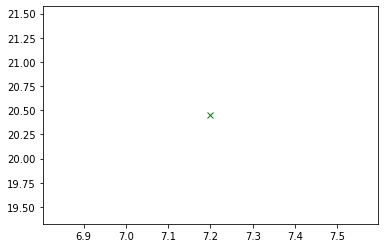

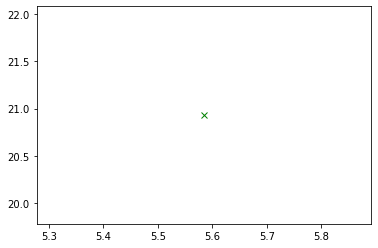

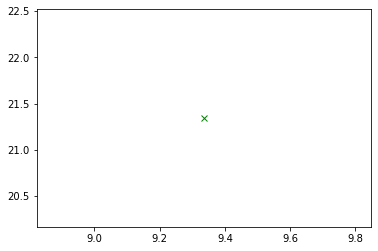

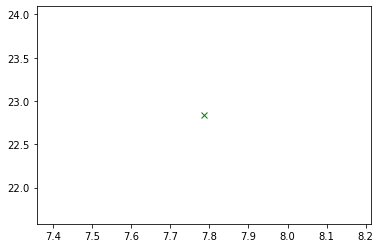

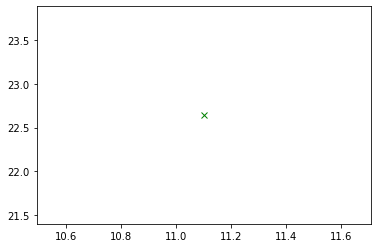

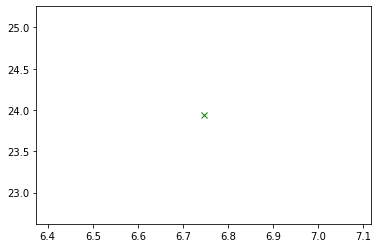

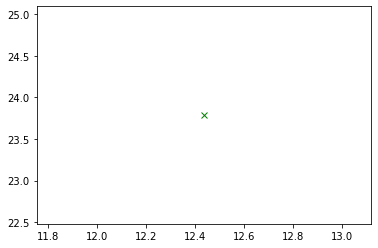

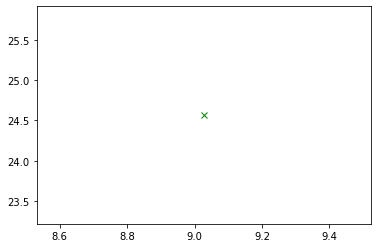

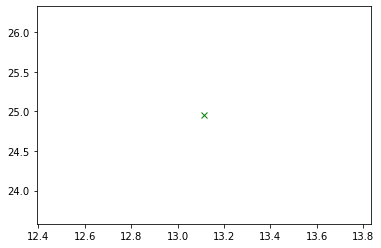

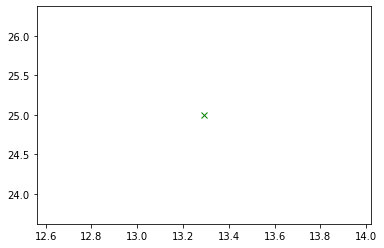

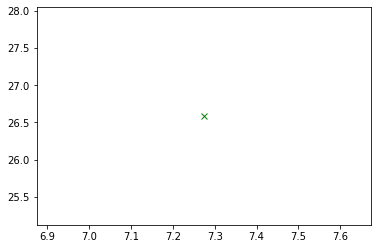

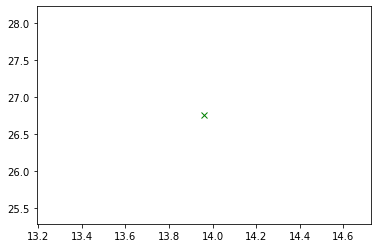

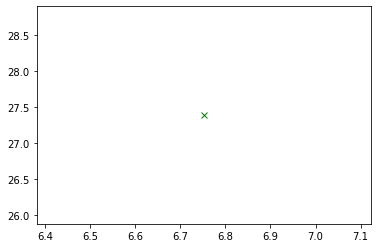

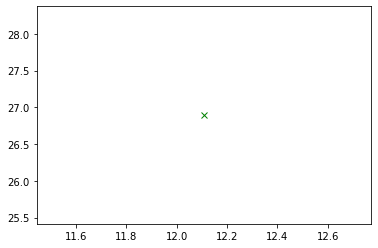

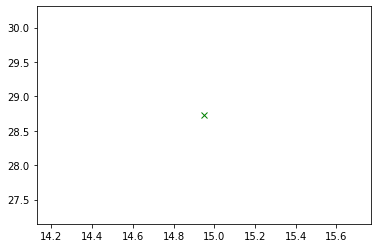

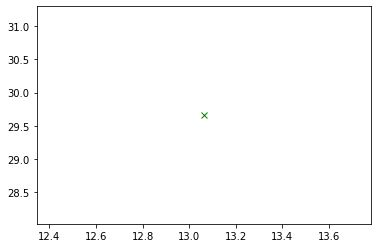

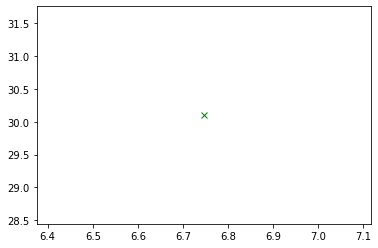

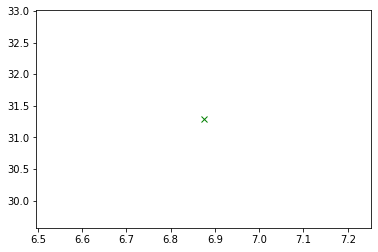

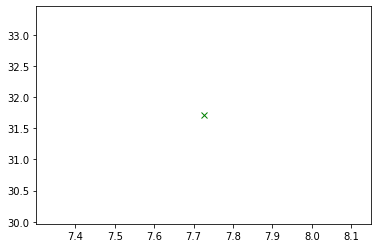

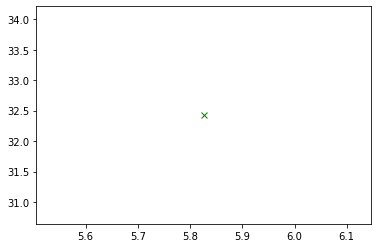

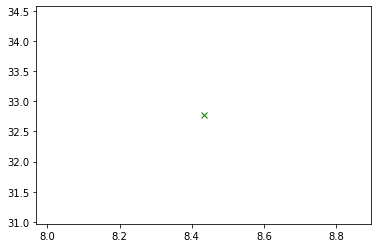

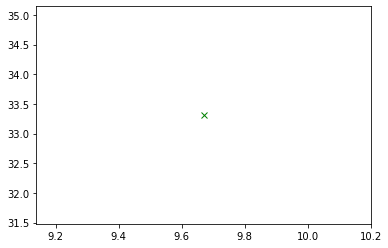

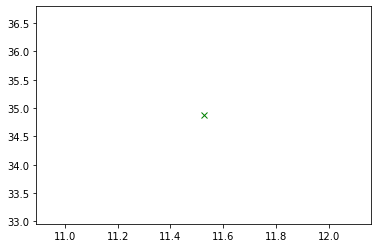

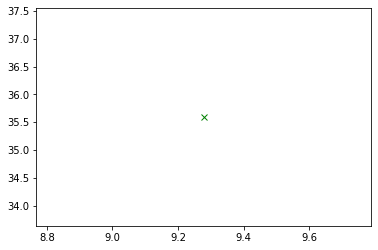

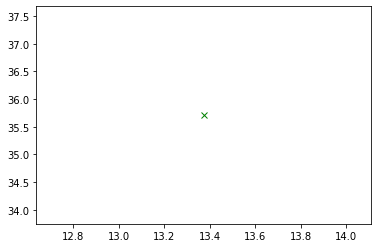

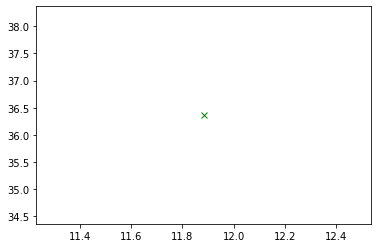

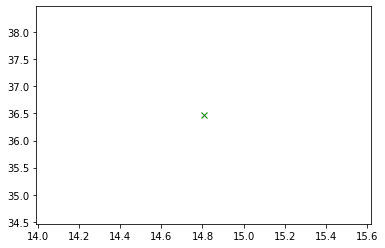

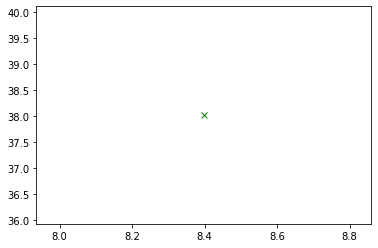

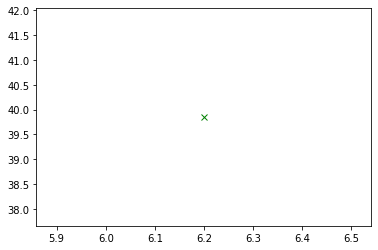

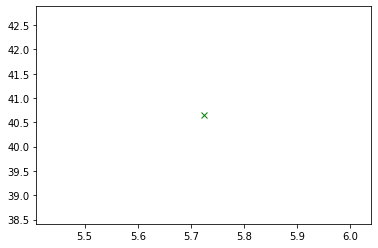

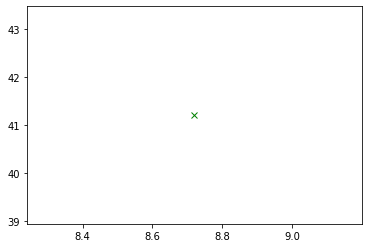

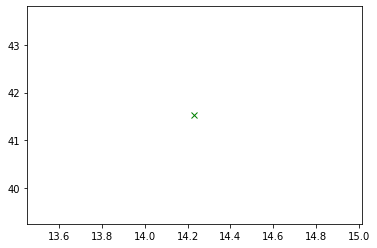

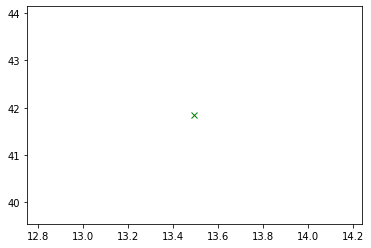

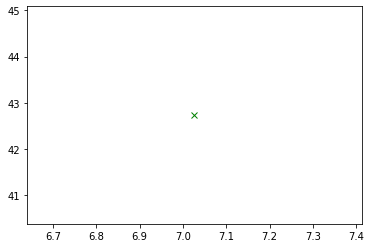

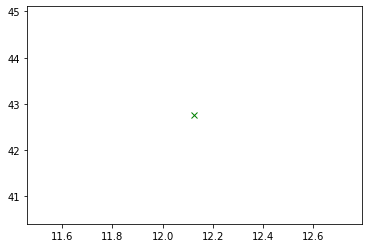

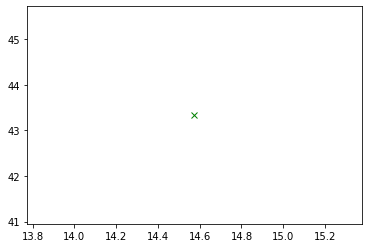

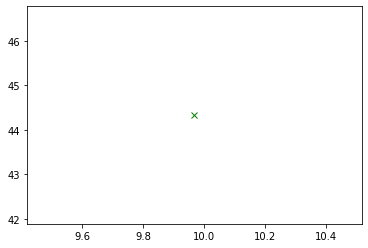

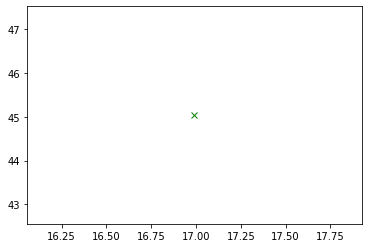

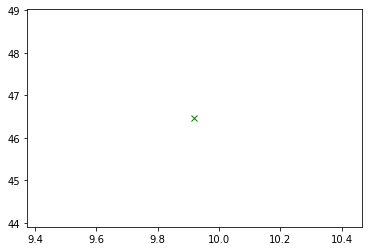

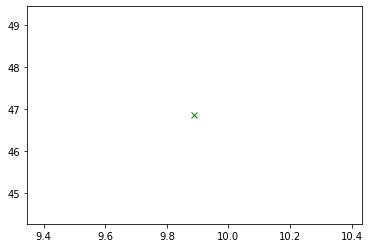

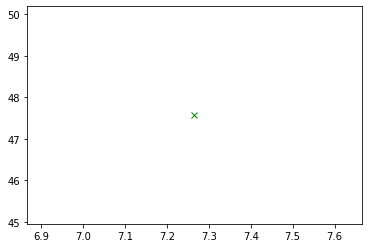

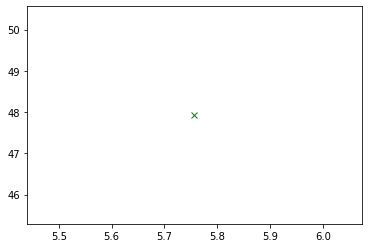

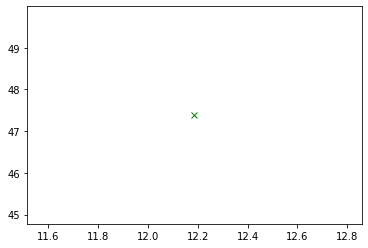

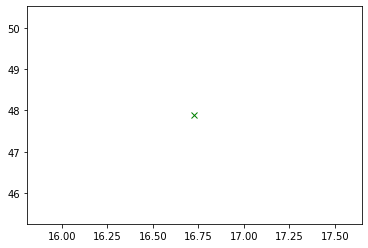

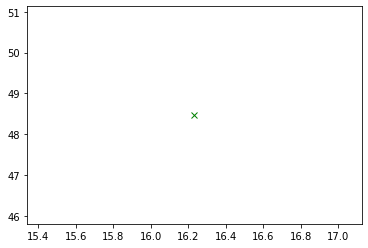

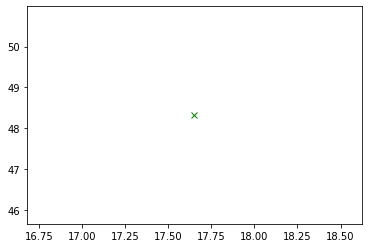

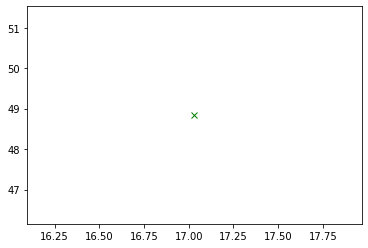

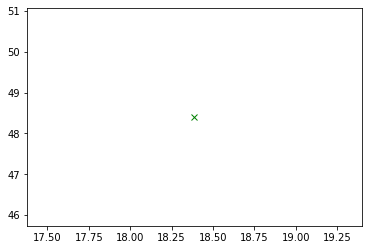

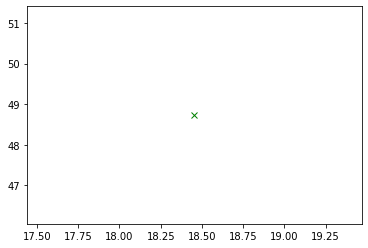

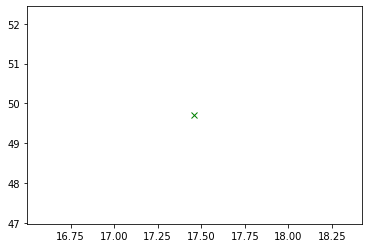

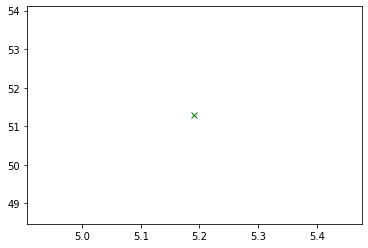

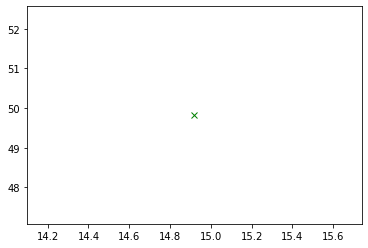

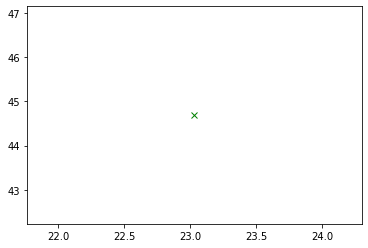

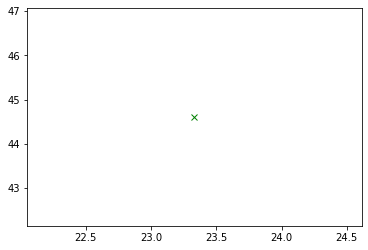

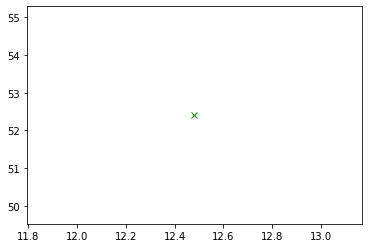

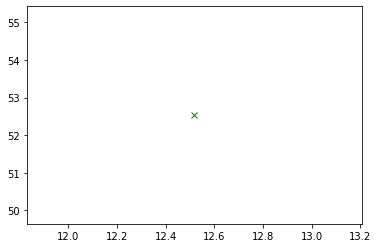

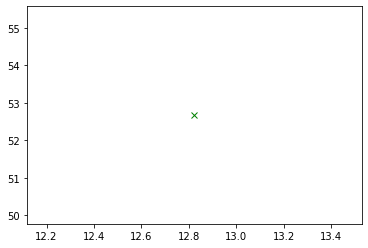

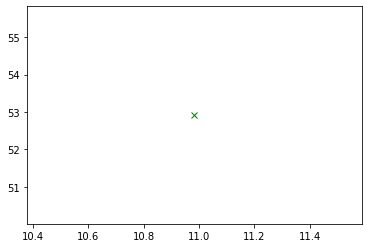

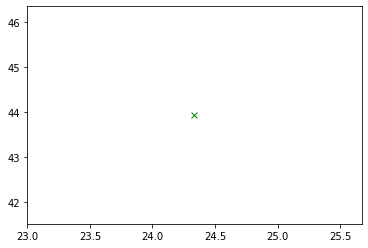

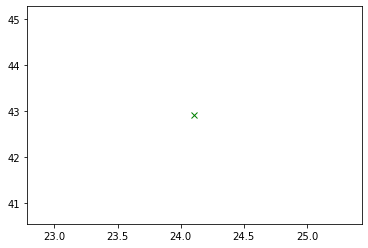

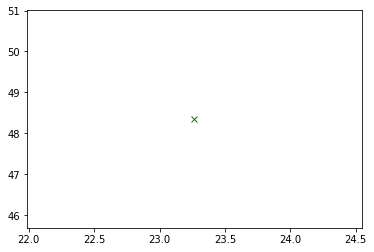

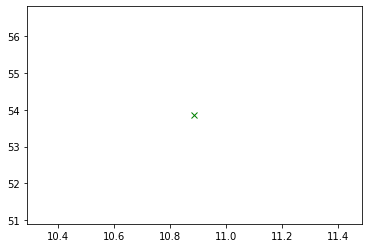

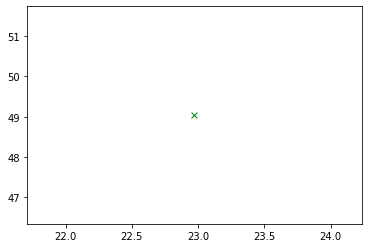

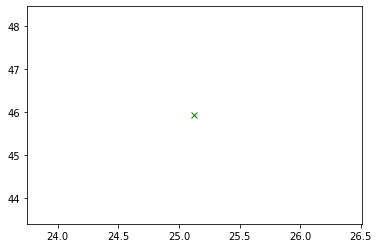

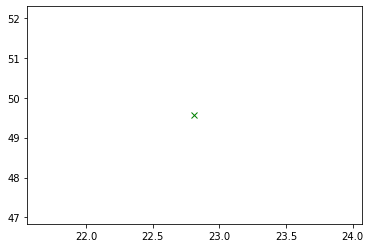

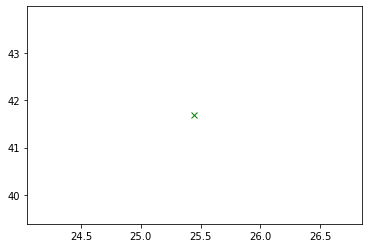

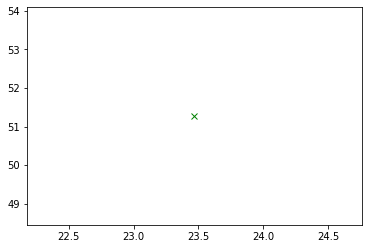

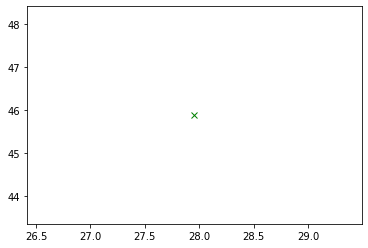

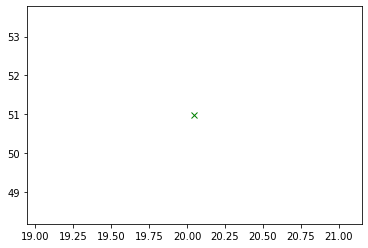

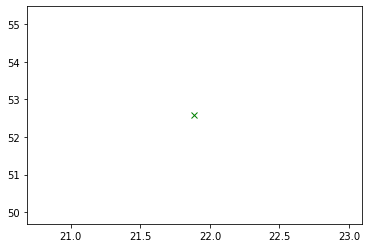

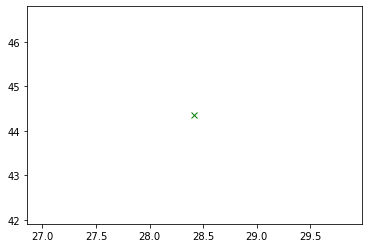

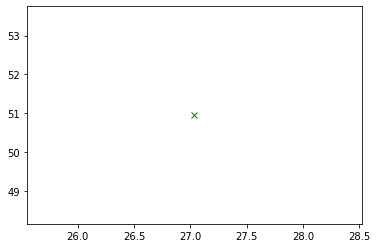

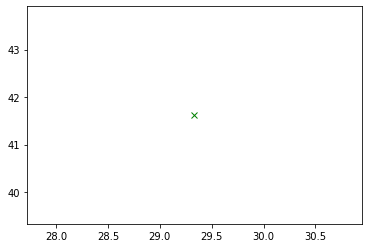

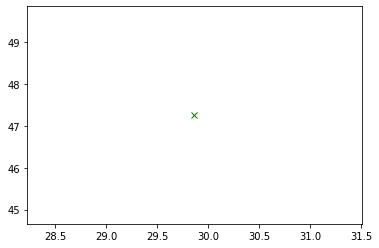

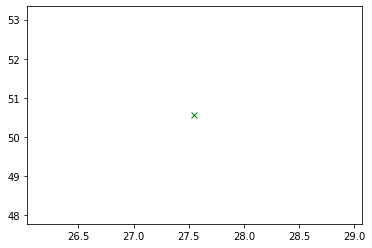

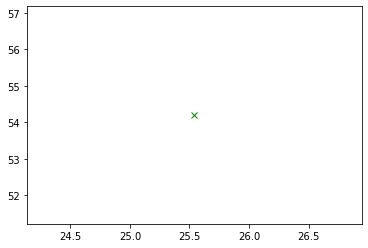

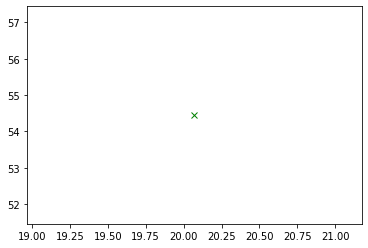

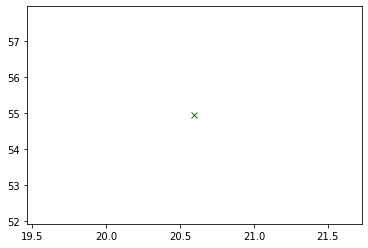

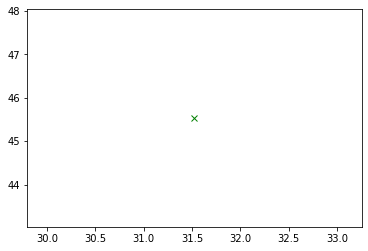

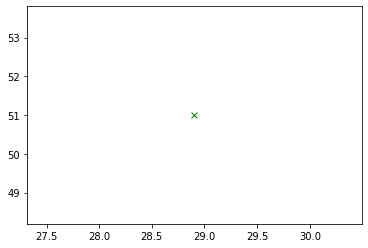

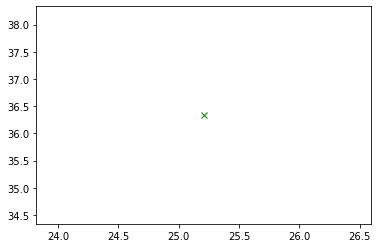

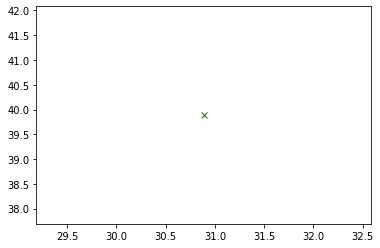

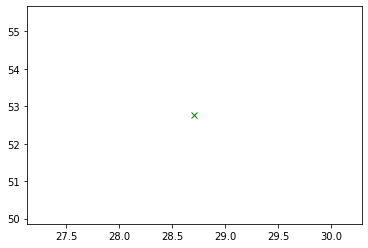

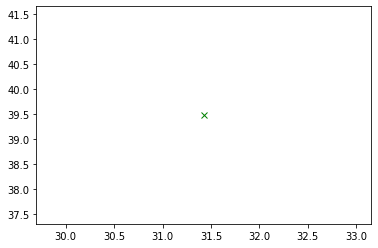

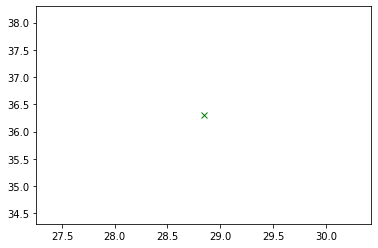

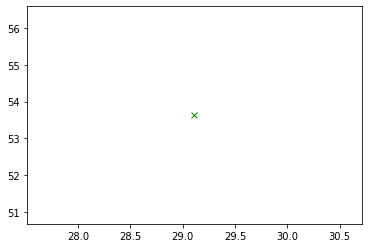

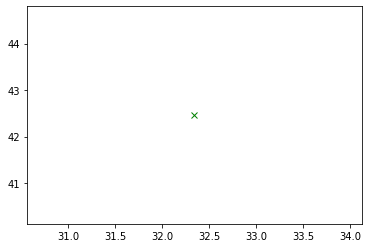

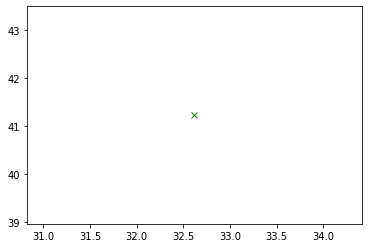

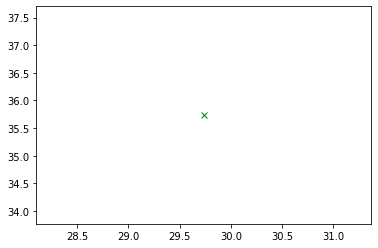

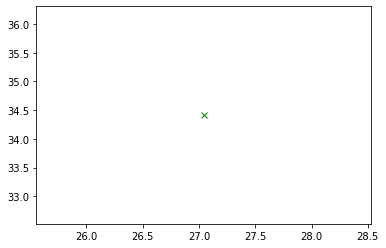

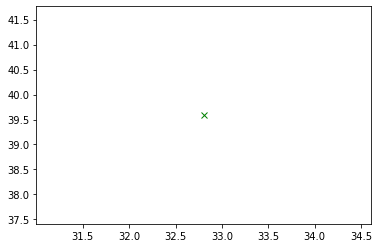

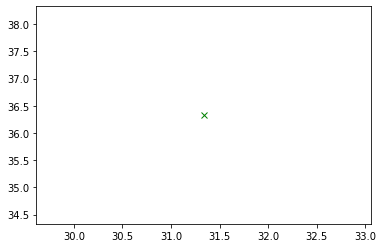

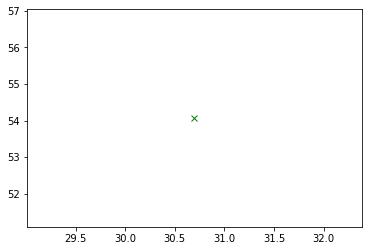

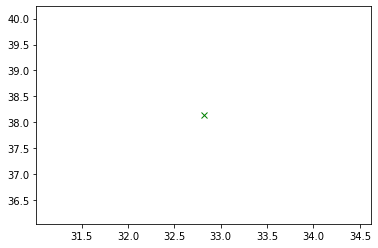

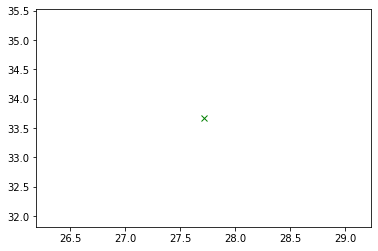

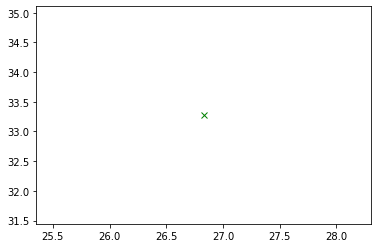

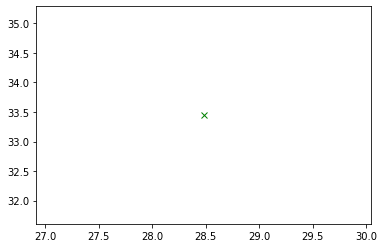

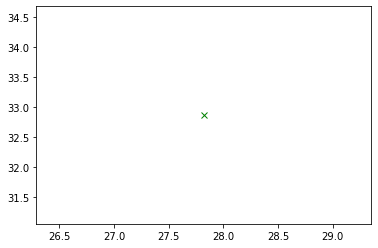

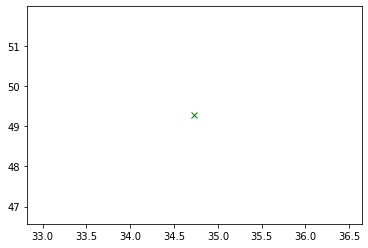

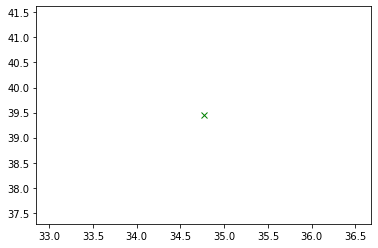

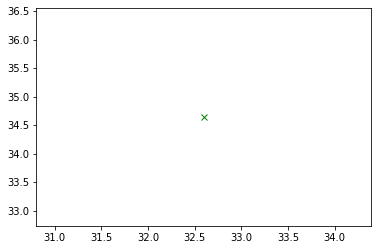

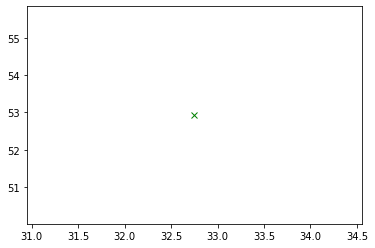

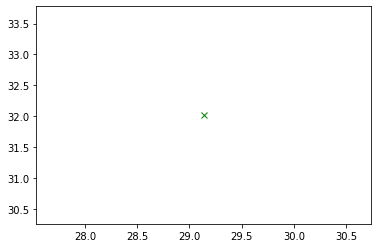

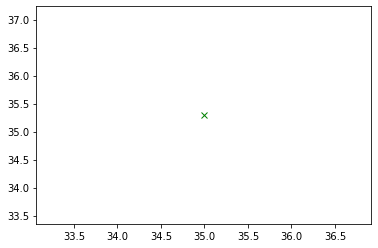

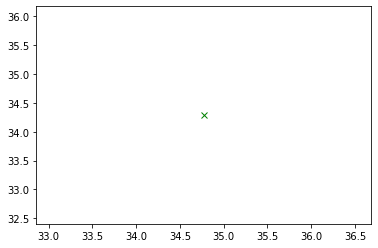

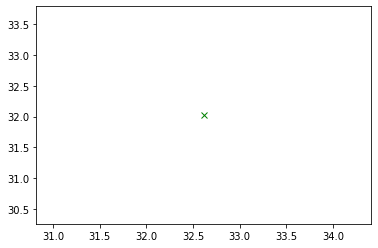

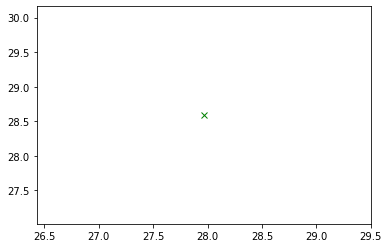

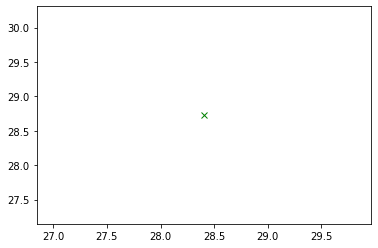

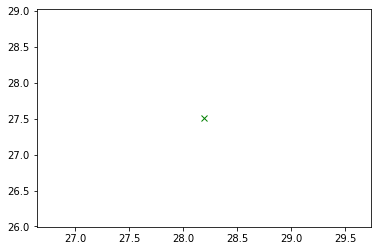

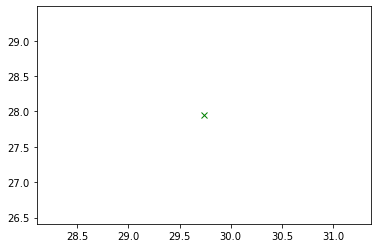

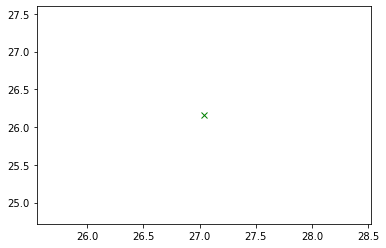

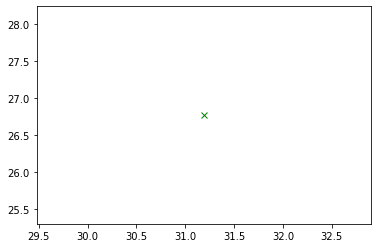

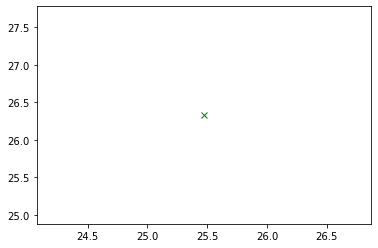

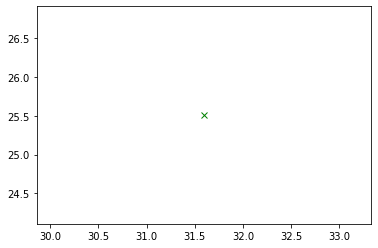

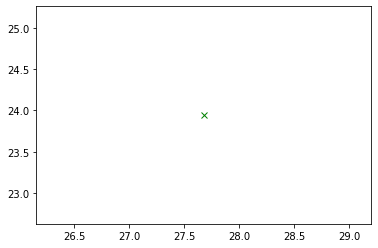

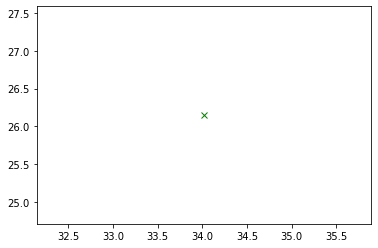

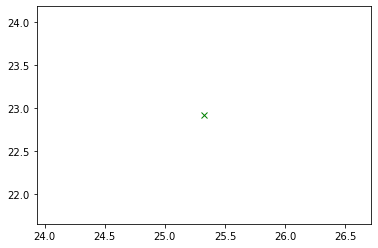

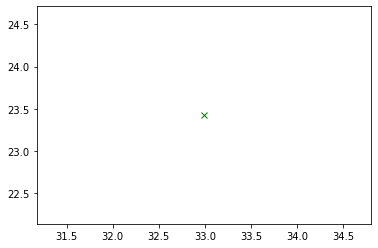

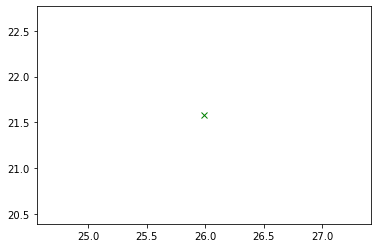

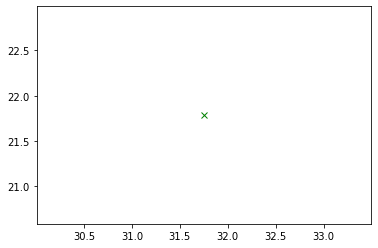

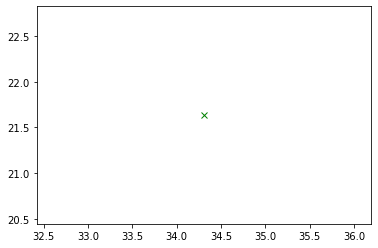

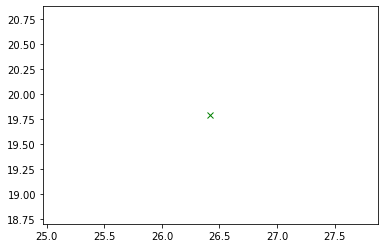

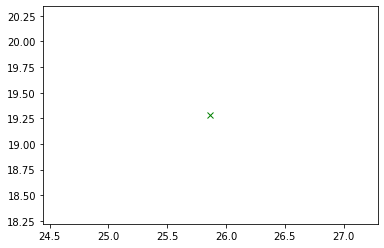

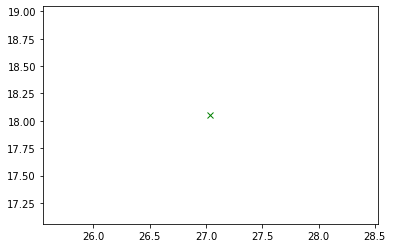

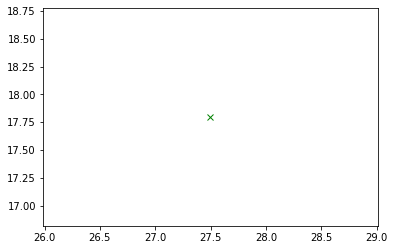

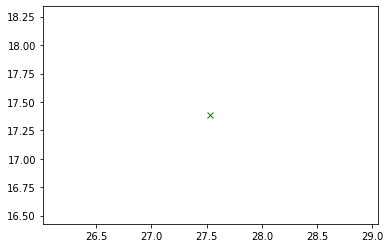

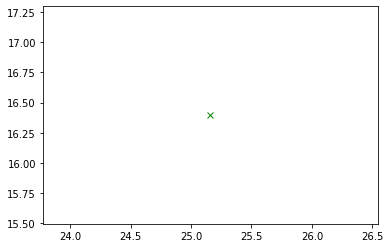

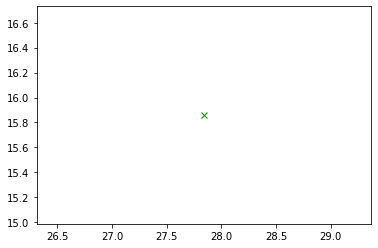

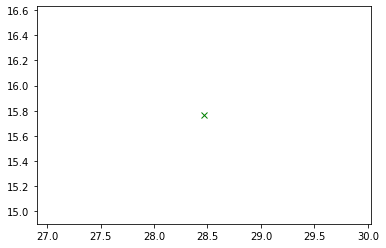

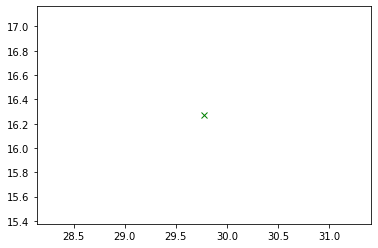

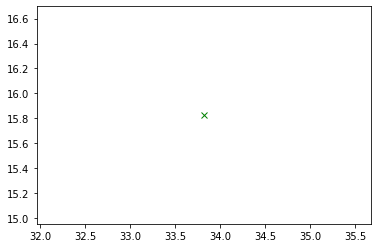

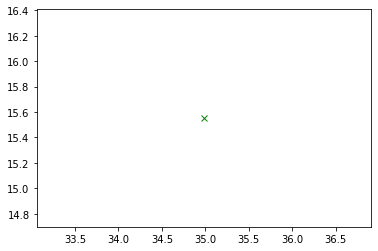

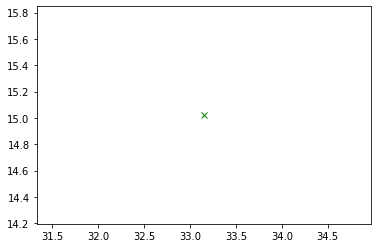

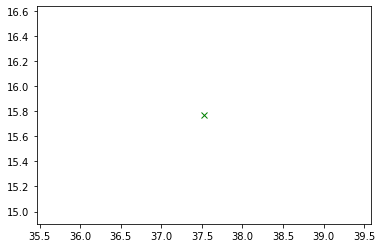

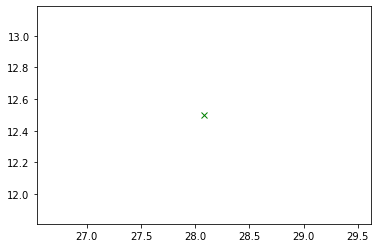

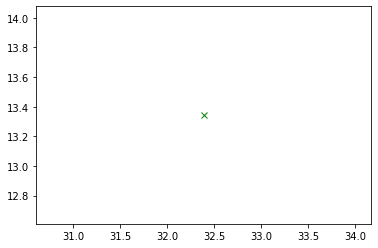

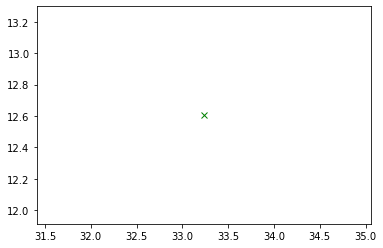

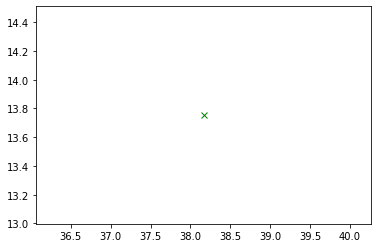

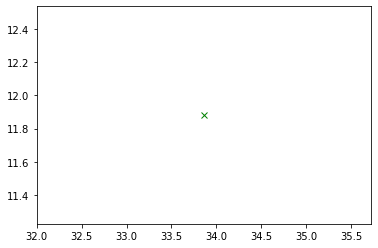

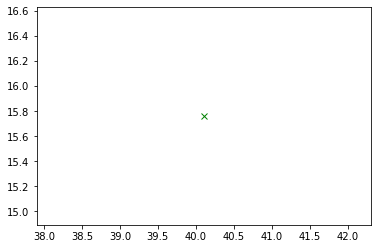

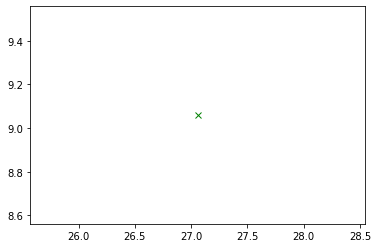

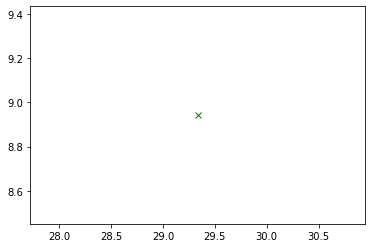

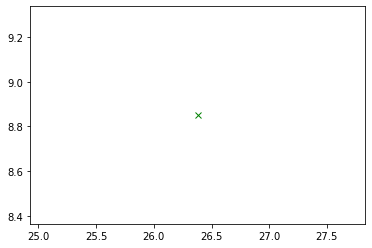

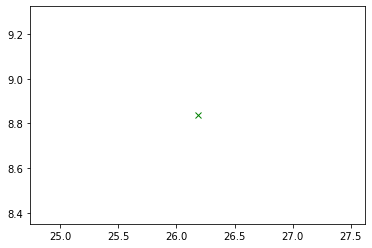

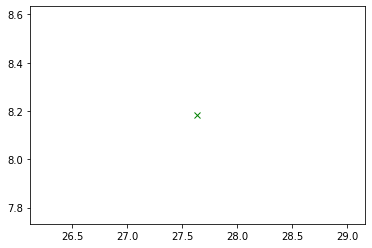

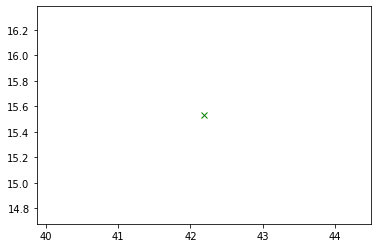

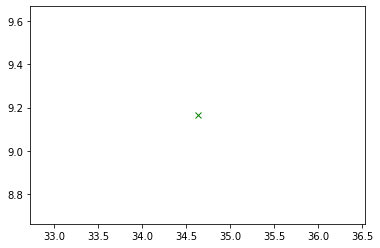

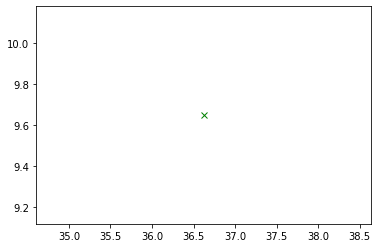

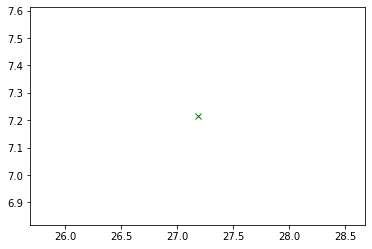

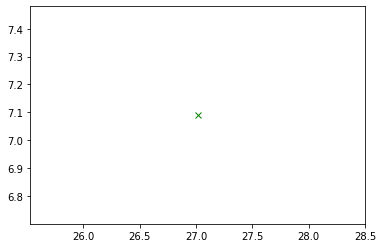

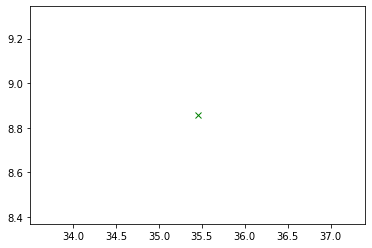

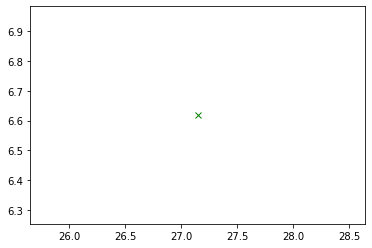

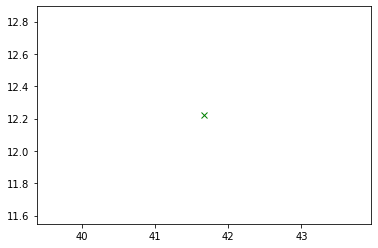

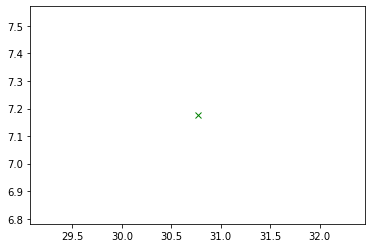

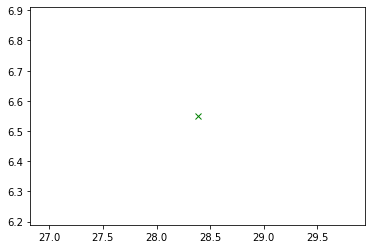

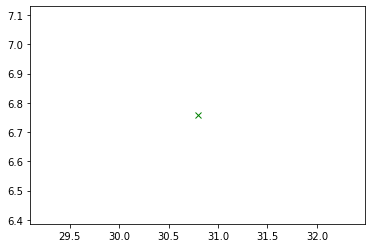

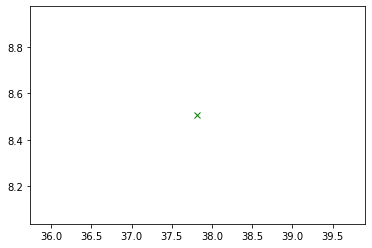

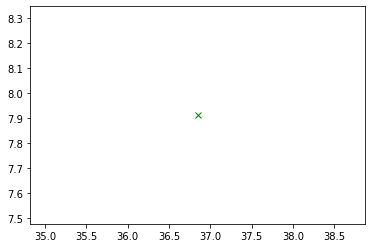

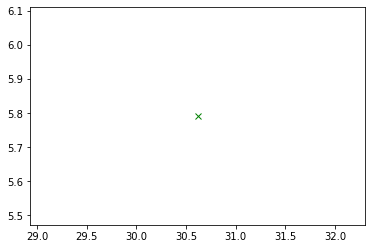

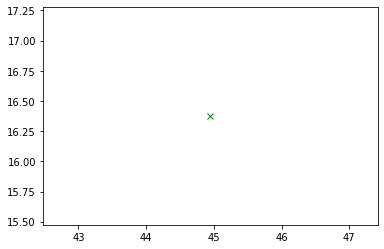

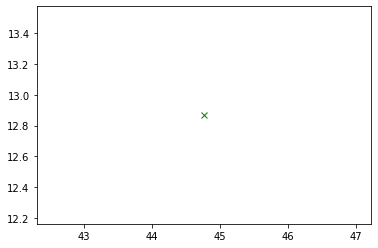

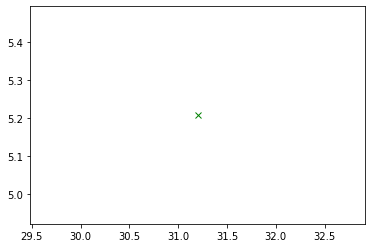

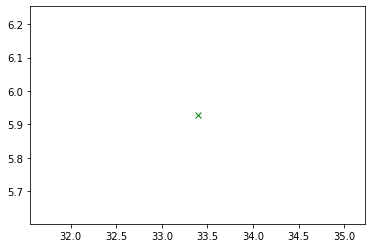

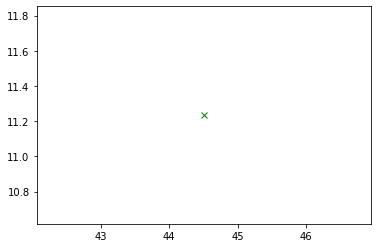

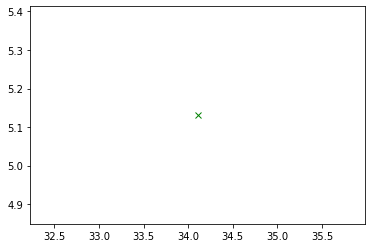

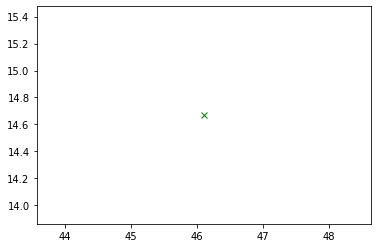

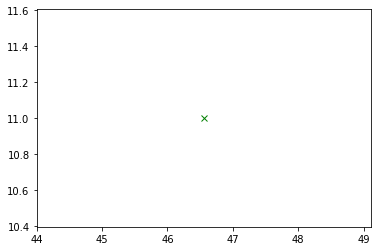

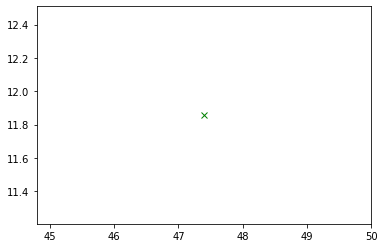

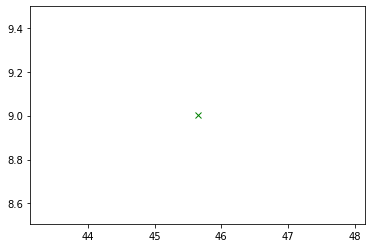

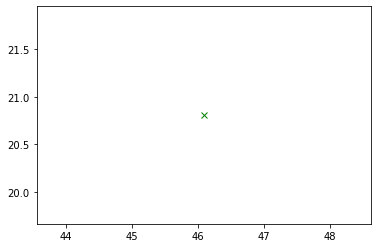

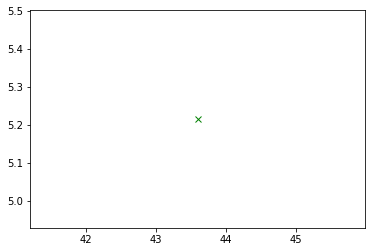

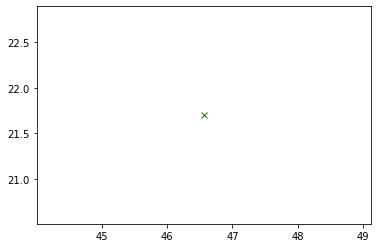

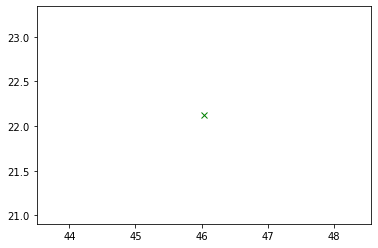

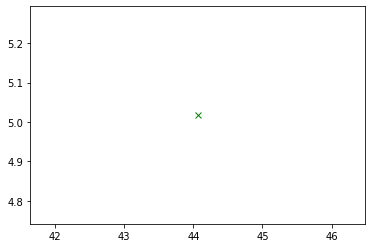

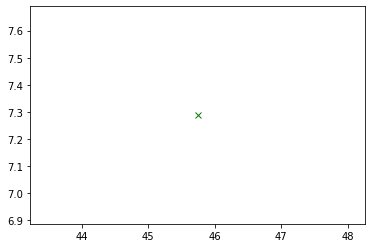

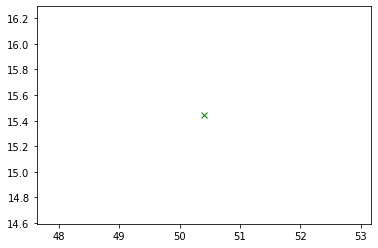

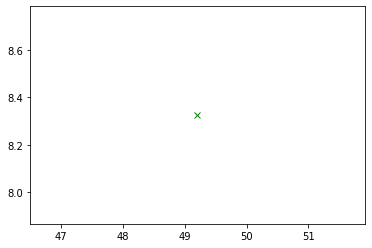

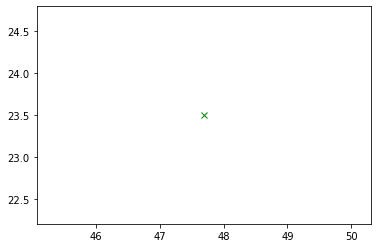

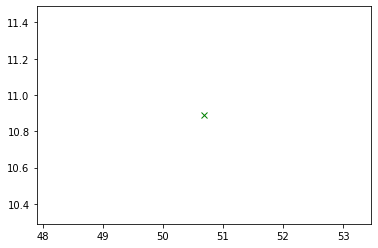

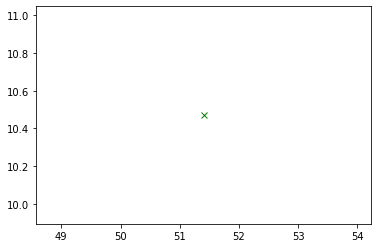

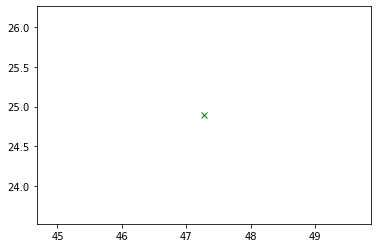

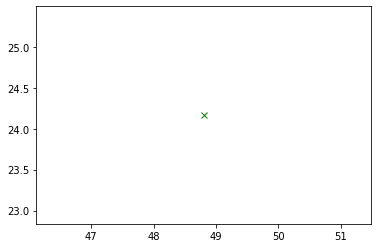

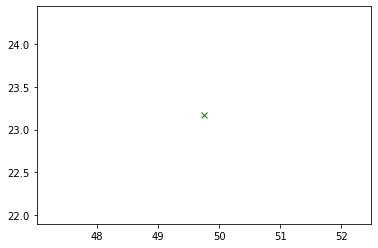

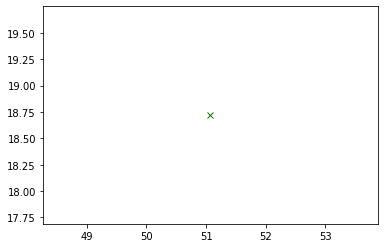

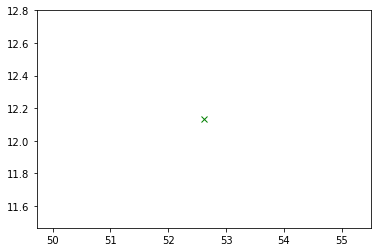

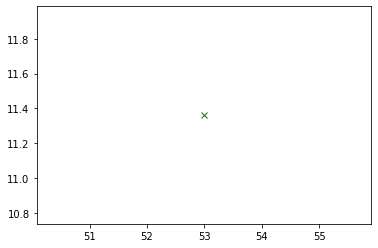

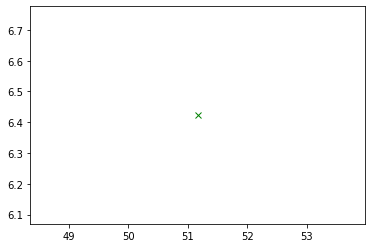

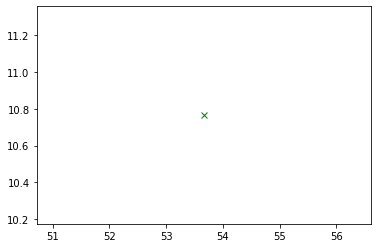

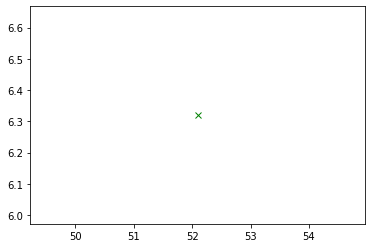

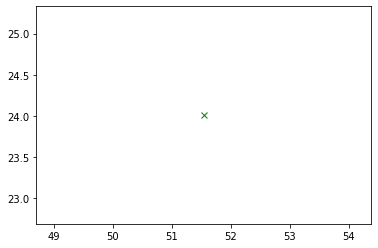

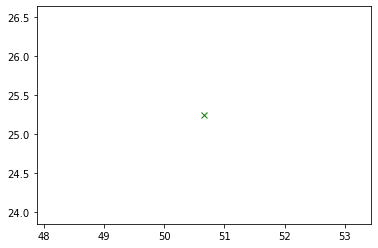

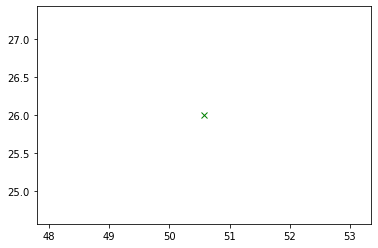

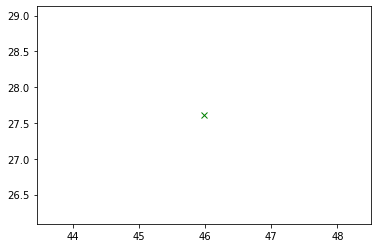

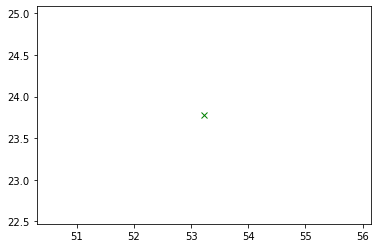

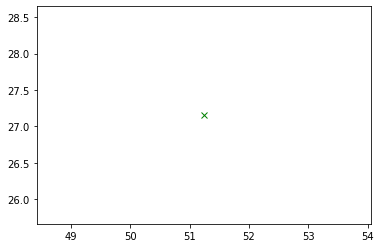

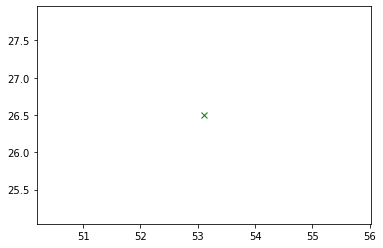

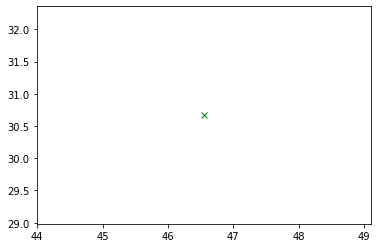

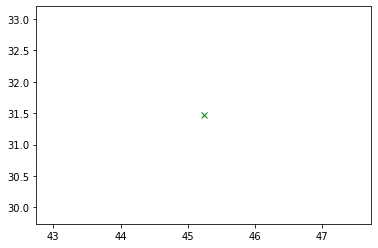

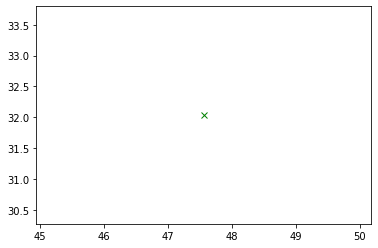

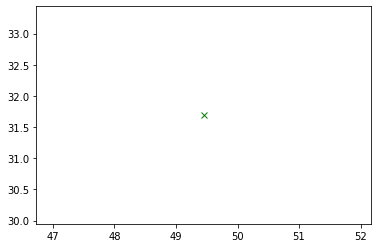

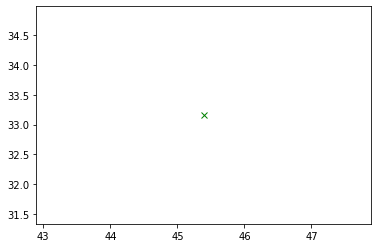

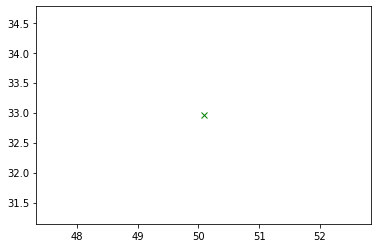

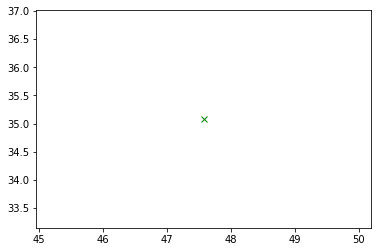

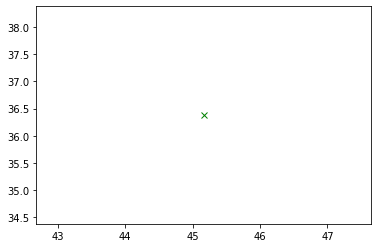

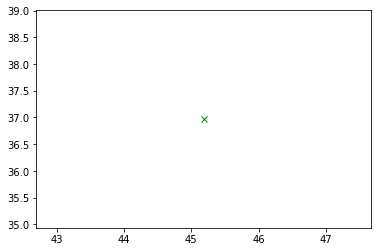

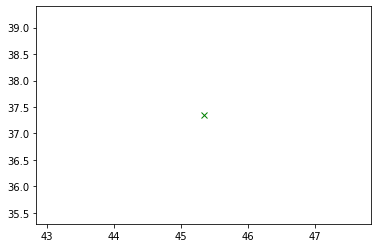

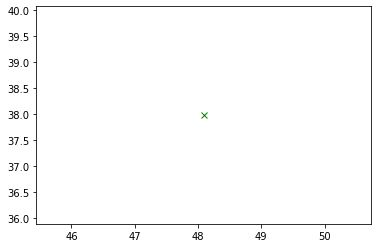

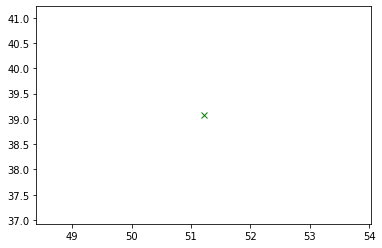

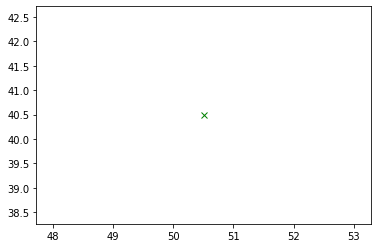

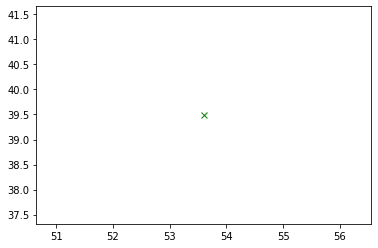

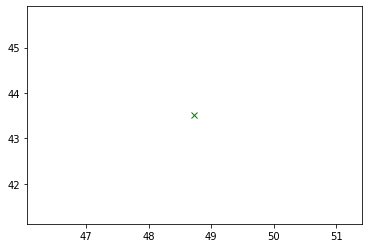

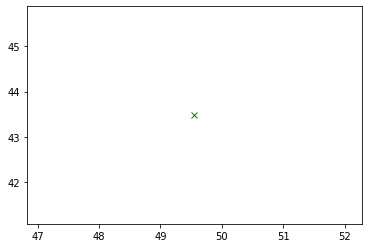

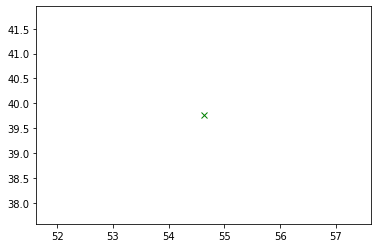

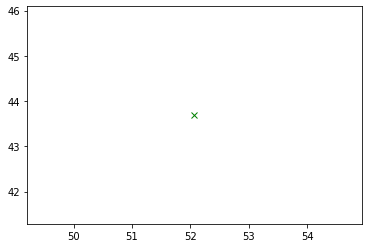

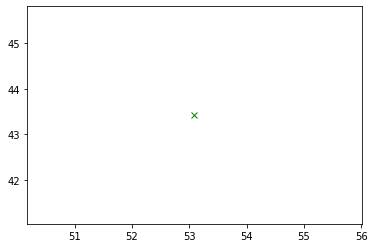

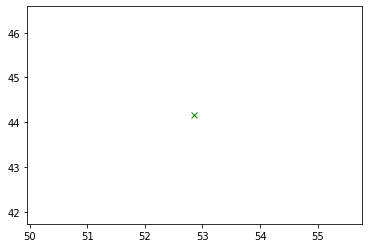

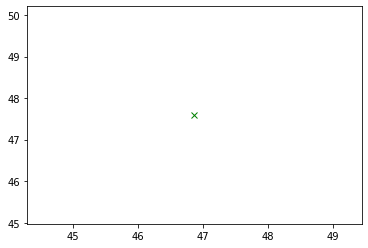

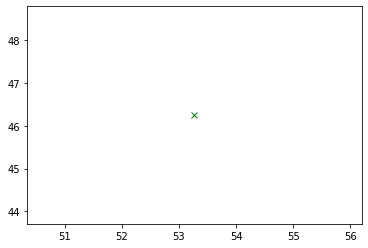

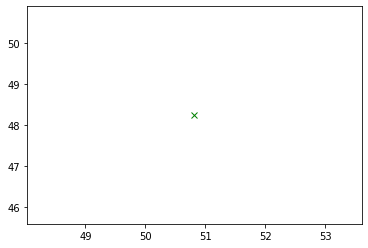

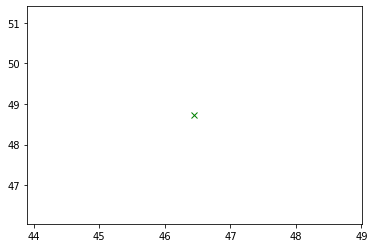

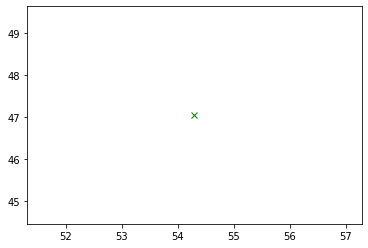

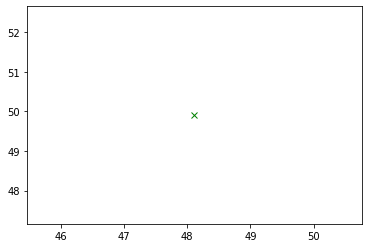

goal is found!


In [4]:
"""
Probabilistic Road Map (PRM) Planner
author: Atsushi Sakai (@Atsushi_twi)
"""

import random
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

# parameter
N_SAMPLE = 500  # number of sample_points
N_KNN = 10  # number of edge from one sampled point
MAX_EDGE_LEN = 30.0  # [m] Maximum edge length

show_animation = True


class Node:
    """
    Node class for dijkstra search
    """

    def __init__(self, x, y, cost, parent_index):
        self.x = x
        self.y = y
        self.cost = cost
        self.parent_index = parent_index

    def __str__(self):
        return str(self.x) + "," + str(self.y) + "," +\
               str(self.cost) + "," + str(self.parent_index)


def prm_planning(sx, sy, gx, gy, ox, oy, rr):

    obstacle_kd_tree = cKDTree(np.vstack((ox, oy)).T)

    sample_x, sample_y = sample_points(sx, sy, gx, gy,
                                       rr, ox, oy, obstacle_kd_tree)
    if show_animation:
        plt.plot(sample_x, sample_y, ".b")

    road_map = generate_road_map(sample_x, sample_y, rr, obstacle_kd_tree)

    rx, ry = dijkstra_planning(
        sx, sy, gx, gy, road_map, sample_x, sample_y)

    return rx, ry


def is_collision(sx, sy, gx, gy, rr, obstacle_kd_tree):
    x = sx
    y = sy
    dx = gx - sx
    dy = gy - sy
    yaw = math.atan2(gy - sy, gx - sx)
    d = math.hypot(dx, dy)

    if d >= MAX_EDGE_LEN:
        return True

    D = rr
    n_step = round(d / D)

    for i in range(n_step):
        dist, _ = obstacle_kd_tree.query([x, y])
        if dist <= rr:
            return True  # collision
        x += D * math.cos(yaw)
        y += D * math.sin(yaw)

    # goal point check
    dist, _ = obstacle_kd_tree.query([gx, gy])
    if dist <= rr:
        return True  # collision

    return False  # OK


def generate_road_map(sample_x, sample_y, rr, obstacle_kd_tree):
    """
    Road map generation
    sample_x: [m] x positions of sampled points
    sample_y: [m] y positions of sampled points
    rr: Robot Radius[m]
    obstacle_kd_tree: KDTree object of obstacles
    """

    road_map = []
    n_sample = len(sample_x)
    sample_kd_tree = cKDTree(np.vstack((sample_x, sample_y)).T)

    for (i, ix, iy) in zip(range(n_sample), sample_x, sample_y):

        dists, indexes = sample_kd_tree.query([ix, iy], k=n_sample)
        edge_id = []

        for ii in range(1, len(indexes)):
            nx = sample_x[indexes[ii]]
            ny = sample_y[indexes[ii]]

            if not is_collision(ix, iy, nx, ny, rr, obstacle_kd_tree):
                edge_id.append(indexes[ii])

            if len(edge_id) >= N_KNN:
                break

        road_map.append(edge_id)

    #  plot_road_map(road_map, sample_x, sample_y)

    return road_map


def dijkstra_planning(sx, sy, gx, gy, road_map, sample_x, sample_y):
    """
    s_x: start x position [m]
    s_y: start y position [m]
    gx: goal x position [m]
    gy: goal y position [m]
    ox: x position list of Obstacles [m]
    oy: y position list of Obstacles [m]
    rr: robot radius [m]
    road_map: ??? [m]
    sample_x: ??? [m]
    sample_y: ??? [m]
    @return: Two lists of path coordinates ([x1, x2, ...], [y1, y2, ...]), empty list when no path was found
    """

    start_node = Node(sx, sy, 0.0, -1)
    goal_node = Node(gx, gy, 0.0, -1)

    open_set, closed_set = dict(), dict()
    open_set[len(road_map) - 2] = start_node

    path_found = True

    while True:
        if not open_set:
            print("Cannot find path")
            path_found = False
            break

        c_id = min(open_set, key=lambda o: open_set[o].cost)
        current = open_set[c_id]

        # show graph
        if show_animation and len(closed_set.keys()) % 2 == 0:
            # for stopping simulation with the esc key.
            plt.gcf().canvas.mpl_connect(
                'key_release_event',
                lambda event: [exit(0) if event.key == 'escape' else None])
            plt.plot(current.x, current.y, "xg")
            plt.pause(0.001)

        if c_id == (len(road_map) - 1):
            print("goal is found!")
            goal_node.parent_index = current.parent_index
            goal_node.cost = current.cost
            break

        # Remove the item from the open set
        del open_set[c_id]
        # Add it to the closed set
        closed_set[c_id] = current

        # expand search grid based on motion model
        for i in range(len(road_map[c_id])):
            n_id = road_map[c_id][i]
            dx = sample_x[n_id] - current.x
            dy = sample_y[n_id] - current.y
            d = math.hypot(dx, dy)
            node = Node(sample_x[n_id], sample_y[n_id],
                        current.cost + d, c_id)

            if n_id in closed_set:
                continue
            # Otherwise if it is already in the open set
            if n_id in open_set:
                if open_set[n_id].cost > node.cost:
                    open_set[n_id].cost = node.cost
                    open_set[n_id].parent_index = c_id
            else:
                open_set[n_id] = node

    if path_found is False:
        return [], []

    # generate final course
    rx, ry = [goal_node.x], [goal_node.y]
    parent_index = goal_node.parent_index
    while parent_index != -1:
        n = closed_set[parent_index]
        rx.append(n.x)
        ry.append(n.y)
        parent_index = n.parent_index

    return rx, ry


def plot_road_map(road_map, sample_x, sample_y):  # pragma: no cover

    for i, _ in enumerate(road_map):
        for ii in range(len(road_map[i])):
            ind = road_map[i][ii]

            plt.plot([sample_x[i], sample_x[ind]],
                     [sample_y[i], sample_y[ind]], "-k")


def sample_points(sx, sy, gx, gy, rr, ox, oy, obstacle_kd_tree):
    max_x = max(ox)
    max_y = max(oy)
    min_x = min(ox)
    min_y = min(oy)

    sample_x, sample_y = [], []

    while len(sample_x) <= N_SAMPLE:
        tx = (random.random() * (max_x - min_x)) + min_x
        ty = (random.random() * (max_y - min_y)) + min_y

        dist, index = obstacle_kd_tree.query([tx, ty])

        if dist >= rr:
            sample_x.append(tx)
            sample_y.append(ty)

    sample_x.append(sx)
    sample_y.append(sy)
    sample_x.append(gx)
    sample_y.append(gy)

    return sample_x, sample_y


def main():
    print(" start!!")

    # start and goal position
    sx = 10.0  # [m]
    sy = 10.0  # [m]
    gx = 50.0  # [m]
    gy = 50.0  # [m]
    robot_size = 5.0  # [m]

    ox = []
    oy = []

    for i in range(60):
        ox.append(i)
        oy.append(0.0)
    for i in range(60):
        ox.append(60.0)
        oy.append(i)
    for i in range(61):
        ox.append(i)
        oy.append(60.0)
    for i in range(61):
        ox.append(0.0)
        oy.append(i)
    for i in range(40):
        ox.append(20.0)
        oy.append(i)
    for i in range(40):
        ox.append(40.0)
        oy.append(60.0 - i)

    if show_animation:
        plt.plot(ox, oy, ".k")
        plt.plot(sx, sy, "^r")
        plt.plot(gx, gy, "^c")
        plt.grid(True)
        plt.axis("equal")

    rx, ry = prm_planning(sx, sy, gx, gy, ox, oy, robot_size)

    assert rx, 'Cannot found path'

#     if show_animation:
#         plt.plot(rx, ry, "-r")
#         plt.pause(0.001)
#         plt.show()


if __name__ == '__main__':
    main()

### Optimization based appoaches
1. Reactive control - potential-based methods
2. Optimization based methods - elastic bands, CHOMP (STOMP, ITOMP) and TrajOpt
3. General nonlinear optimization strategy: 
$$ min_{\theta_1...\theta_T} \sum_t \vert \vert \theta_{t+1} - \theta_{t}\vert \vert_2+other~costs$$
$$s.t. \theta_0 = start~state, \theta_t = goal~state$$
$$satisfy~joint~limits$$
$$no~collision$$
4. Despite the first few constraints being linear/convex, the last requirement on collision can be non-convex. To handle this non-convexity, we can use sequential convex optimization to approximate the problem locally with a convex optimization problem.
5. Typically, collision avoidance is added via a penalty-based function using the signed distance function using a hinge loss function.

#### Continuous time safety
1. Collision check against swept-out volume. This is faster
2. 

#### Sequential convex optimization


In [3]:

"""
RRT* path planner for a seven joint arm
Author: Mahyar Abdeetedal (mahyaret)
"""
import math
import os
import sys
import random
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
sys.path.append(os.path.dirname(os.path.abspath(__file__)) +
                "/../n_joint_arm_3d/")
try:
    from NLinkArm3d import NLinkArm
except ImportError:
    raise

show_animation = True
verbose = False


class RobotArm(NLinkArm):
    def get_points(self, joint_angle_list):
        self.set_joint_angles(joint_angle_list)

        x_list = []
        y_list = []
        z_list = []

        trans = np.identity(4)

        x_list.append(trans[0, 3])
        y_list.append(trans[1, 3])
        z_list.append(trans[2, 3])
        for i in range(len(self.link_list)):
            trans = np.dot(trans, self.link_list[i].transformation_matrix())
            x_list.append(trans[0, 3])
            y_list.append(trans[1, 3])
            z_list.append(trans[2, 3])

        return x_list, y_list, z_list


class RRTStar:
    """
    Class for RRT Star planning
    """

    class Node:
        def __init__(self, x):
            self.x = x
            self.parent = None
            self.cost = 0.0

    def __init__(self, start, goal, robot, obstacle_list, rand_area,
                 expand_dis=.30,
                 path_resolution=.1,
                 goal_sample_rate=20,
                 max_iter=300,
                 connect_circle_dist=50.0
                 ):
        """
        Setting Parameter
        start:Start Position [q1,...,qn]
        goal:Goal Position [q1,...,qn]
        obstacleList:obstacle Positions [[x,y,z,size],...]
        randArea:Random Sampling Area [min,max]
        """
        self.start = self.Node(start)
        self.end = self.Node(goal)
        self.dimension = len(start)
        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]
        self.expand_dis = expand_dis
        self.path_resolution = path_resolution
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.robot = robot
        self.obstacle_list = obstacle_list
        self.connect_circle_dist = connect_circle_dist
        self.goal_node = self.Node(goal)
        self.ax = plt.axes(projection='3d')
        self.node_list = []

    def planning(self, animation=False, search_until_max_iter=False):
        """
        rrt star path planning
        animation: flag for animation on or off
        search_until_max_iter: search until max iteration for path
        improving or not
        """

        self.node_list = [self.start]
        for i in range(self.max_iter):
            if verbose:
                print("Iter:", i, ", number of nodes:", len(self.node_list))
            rnd = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd)
            new_node = self.steer(self.node_list[nearest_ind],
                                  rnd,
                                  self.expand_dis)

            if self.check_collision(new_node, self.robot, self.obstacle_list):
                near_inds = self.find_near_nodes(new_node)
                new_node = self.choose_parent(new_node, near_inds)
                if new_node:
                    self.node_list.append(new_node)
                    self.rewire(new_node, near_inds)

            if animation and i % 5 == 0 and self.dimension <= 3:
                self.draw_graph(rnd)

            if (not search_until_max_iter) and new_node:
                last_index = self.search_best_goal_node()
                if last_index is not None:
                    return self.generate_final_course(last_index)
        if verbose:
            print("reached max iteration")

        last_index = self.search_best_goal_node()
        if last_index is not None:
            return self.generate_final_course(last_index)

        return None

    def choose_parent(self, new_node, near_inds):
        if not near_inds:
            return None

        # search nearest cost in near_inds
        costs = []
        for i in near_inds:
            near_node = self.node_list[i]
            t_node = self.steer(near_node, new_node)
            if t_node and self.check_collision(t_node,
                                               self.robot,
                                               self.obstacle_list):
                costs.append(self.calc_new_cost(near_node, new_node))
            else:
                costs.append(float("inf"))  # the cost of collision node
        min_cost = min(costs)

        if min_cost == float("inf"):
            print("There is no good path.(min_cost is inf)")
            return None

        min_ind = near_inds[costs.index(min_cost)]
        new_node = self.steer(self.node_list[min_ind], new_node)
        new_node.parent = self.node_list[min_ind]
        new_node.cost = min_cost

        return new_node

    def search_best_goal_node(self):
        dist_to_goal_list = [self.calc_dist_to_goal(n.x)
                             for n in self.node_list]
        goal_inds = [dist_to_goal_list.index(i)
                     for i in dist_to_goal_list if i <= self.expand_dis]

        safe_goal_inds = []
        for goal_ind in goal_inds:
            t_node = self.steer(self.node_list[goal_ind], self.goal_node)
            if self.check_collision(t_node, self.robot, self.obstacle_list):
                safe_goal_inds.append(goal_ind)

        if not safe_goal_inds:
            return None

        min_cost = min([self.node_list[i].cost for i in safe_goal_inds])
        for i in safe_goal_inds:
            if self.node_list[i].cost == min_cost:
                return i

        return None

    def find_near_nodes(self, new_node):
        nnode = len(self.node_list) + 1
        r = self.connect_circle_dist * math.sqrt((math.log(nnode) / nnode))
        # if expand_dist exists, search vertices in
        # a range no more than expand_dist
        if hasattr(self, 'expand_dis'):
            r = min(r, self.expand_dis)
        dist_list = [np.sum((np.array(node.x) - np.array(new_node.x)) ** 2)
                     for node in self.node_list]
        near_inds = [dist_list.index(i) for i in dist_list if i <= r ** 2]
        return near_inds

    def rewire(self, new_node, near_inds):
        for i in near_inds:
            near_node = self.node_list[i]
            edge_node = self.steer(new_node, near_node)
            if not edge_node:
                continue
            edge_node.cost = self.calc_new_cost(new_node, near_node)

            no_collision = self.check_collision(edge_node,
                                                self.robot,
                                                self.obstacle_list)
            improved_cost = near_node.cost > edge_node.cost

            if no_collision and improved_cost:
                self.node_list[i] = edge_node
                self.propagate_cost_to_leaves(new_node)

    def calc_new_cost(self, from_node, to_node):
        d, _, _ = self.calc_distance_and_angle(from_node, to_node)
        return from_node.cost + d

    def propagate_cost_to_leaves(self, parent_node):

        for node in self.node_list:
            if node.parent == parent_node:
                node.cost = self.calc_new_cost(parent_node, node)
                self.propagate_cost_to_leaves(node)

    def generate_final_course(self, goal_ind):
        path = [self.end.x]
        node = self.node_list[goal_ind]
        while node.parent is not None:
            path.append(node.x)
            node = node.parent
        path.append(node.x)
        reversed(path)
        return path

    def calc_dist_to_goal(self, x):
        distance = np.linalg.norm(np.array(x) - np.array(self.end.x))
        return distance

    def get_random_node(self):
        if random.randint(0, 100) > self.goal_sample_rate:
            rnd = self.Node(np.random.uniform(self.min_rand,
                                              self.max_rand,
                                              self.dimension))
        else:  # goal point sampling
            rnd = self.Node(self.end.x)
        return rnd

    def steer(self, from_node, to_node, extend_length=float("inf")):
        new_node = self.Node(list(from_node.x))
        d, phi, theta = self.calc_distance_and_angle(new_node, to_node)

        new_node.path_x = [list(new_node.x)]

        if extend_length > d:
            extend_length = d

        n_expand = math.floor(extend_length / self.path_resolution)

        start, end = np.array(from_node.x), np.array(to_node.x)
        v = end - start
        u = v / (np.sqrt(np.sum(v ** 2)))
        for _ in range(n_expand):
            new_node.x += u * self.path_resolution
            new_node.path_x.append(list(new_node.x))

        d, _, _ = self.calc_distance_and_angle(new_node, to_node)
        if d <= self.path_resolution:
            new_node.path_x.append(list(to_node.x))

        new_node.parent = from_node

        return new_node

    def draw_graph(self, rnd=None):
        plt.cla()
        self.ax.axis([-1, 1, -1, 1])
        self.ax.set_zlim(0, 1)
        self.ax.grid(True)
        for (ox, oy, oz, size) in self.obstacle_list:
            self.plot_sphere(self.ax, ox, oy, oz, size=size)
        if self.dimension > 3:
            return self.ax
        if rnd is not None:
            self.ax.plot([rnd.x[0]], [rnd.x[1]], [rnd.x[2]], "^k")
        for node in self.node_list:
            if node.parent:
                path = np.array(node.path_x)
                plt.plot(path[:, 0], path[:, 1], path[:, 2], "-g")
        self.ax.plot([self.start.x[0]], [self.start.x[1]],
                     [self.start.x[2]], "xr")
        self.ax.plot([self.end.x[0]], [self.end.x[1]], [self.end.x[2]], "xr")
        plt.pause(0.01)
        return self.ax

    @staticmethod
    def get_nearest_node_index(node_list, rnd_node):
        dlist = [np.sum((np.array(node.x) - np.array(rnd_node.x))**2)
                 for node in node_list]
        minind = dlist.index(min(dlist))

        return minind

    @staticmethod
    def plot_sphere(ax, x, y, z, size=1, color="k"):
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        xl = x+size*np.cos(u)*np.sin(v)
        yl = y+size*np.sin(u)*np.sin(v)
        zl = z+size*np.cos(v)
        ax.plot_wireframe(xl, yl, zl, color=color)

    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node.x[0] - from_node.x[0]
        dy = to_node.x[1] - from_node.x[1]
        dz = to_node.x[2] - from_node.x[2]
        d = np.sqrt(np.sum((np.array(to_node.x) - np.array(from_node.x))**2))
        phi = math.atan2(dy, dx)
        theta = math.atan2(math.hypot(dx, dy), dz)
        return d, phi, theta

    @staticmethod
    def calc_distance_and_angle2(from_node, to_node):
        dx = to_node.x[0] - from_node.x[0]
        dy = to_node.x[1] - from_node.x[1]
        dz = to_node.x[2] - from_node.x[2]
        d = math.sqrt(dx**2 + dy**2 + dz**2)
        phi = math.atan2(dy, dx)
        theta = math.atan2(math.hypot(dx, dy), dz)
        return d, phi, theta

    @staticmethod
    def check_collision(node, robot, obstacleList):

        if node is None:
            return False

        for (ox, oy, oz, size) in obstacleList:
            for x in node.path_x:
                x_list, y_list, z_list = robot.get_points(x)
                dx_list = [ox - x_point for x_point in x_list]
                dy_list = [oy - y_point for y_point in y_list]
                dz_list = [oz - z_point for z_point in z_list]
                d_list = [dx * dx + dy * dy + dz * dz
                          for (dx, dy, dz) in zip(dx_list,
                                                  dy_list,
                                                  dz_list)]

                if min(d_list) <= size ** 2:
                    return False  # collision

        return True  # safe


def main():
    print("Start " + __file__)

    # init NLinkArm with Denavit-Hartenberg parameters of panda
    # https://frankaemika.github.io/docs/control_parameters.html
    # [theta, alpha, a, d]
    seven_joint_arm = RobotArm([[0., math.pi/2., 0., .333],
                                [0., -math.pi/2., 0., 0.],
                                [0., math.pi/2., 0.0825, 0.3160],
                                [0., -math.pi/2., -0.0825, 0.],
                                [0., math.pi/2., 0., 0.3840],
                                [0., math.pi/2., 0.088, 0.],
                                [0., 0., 0., 0.107]])
    # ====Search Path with RRT====
    obstacle_list = [
        (-.3, -.3, .7, .1),
        (.0, -.3, .7, .1),
        (.2, -.1, .3, .15),
    ]  # [x,y,size(radius)]
    start = [0 for _ in range(len(seven_joint_arm.link_list))]
    end = [1.5 for _ in range(len(seven_joint_arm.link_list))]
    # Set Initial parameters
    rrt_star = RRTStar(start=start,
                       goal=end,
                       rand_area=[0, 2],
                       max_iter=200,
                       robot=seven_joint_arm,
                       obstacle_list=obstacle_list)
    path = rrt_star.planning(animation=show_animation,
                             search_until_max_iter=False)

    if path is None:
        print("Cannot find path")
    else:
        print("found path!!")

        # Draw final path
        if show_animation:
            ax = rrt_star.draw_graph()

            # Plot final configuration
            x_points, y_points, z_points = seven_joint_arm.get_points(path[-1])
            ax.plot([x for x in x_points],
                    [y for y in y_points],
                    [z for z in z_points],
                    "o-", color="red", ms=5, mew=0.5)

            for i, q in enumerate(path):
                x_points, y_points, z_points = seven_joint_arm.get_points(q)
                ax.plot([x for x in x_points],
                        [y for y in y_points],
                        [z for z in z_points],
                        "o-", color="grey",  ms=4, mew=0.5)
                plt.pause(0.01)

            plt.show()


if __name__ == '__main__':
    main()

NameError: name '__file__' is not defined